# Imports and Installs

In [243]:
!pip install yfinance

In [244]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
gdown 5.2.0 at /usr/local/lib/python3.10/dist-packages


In [245]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies
* including newly defined "month-week_of_month"

## 0.1) Read and truncate data (last 25 years from 2000), define variable sets


In [246]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
# truncated data from Module 2: https://drive.google.com/file/d/1m3Qisfs2XfWk6Sw_Uk5kHLWqwQ0q8SKb/view?usp=sharing
!gdown https://drive.google.com/file/d/1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP/view?usp=sharing --fuzzy -O /content/

Downloading...
From (original): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP
From (redirected): https://drive.google.com/uc?id=1kNWWPi49td0EZhmi6LzNCa2ssC5IUxHP&confirm=t&uuid=94b29df8-3a3d-4463-bf3e-6ca975bf9fda
To: /content/stocks_df_combined_2024_05_07.parquet.brotli
100% 119M/119M [00:06<00:00, 18.9MB/s]


In [247]:
# truncated
# df = pd.read_parquet("/content/stocks_df_combined_trunc_2014_2023.parquet.brotli", )

# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2024_05_07.parquet.brotli", )

In [248]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221142 entries, 0 to 5426
Columns: 202 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(128), int32(64), int64(5), object(2)
memory usage: 288.5+ MB


In [249]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [250]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Adj Close_x','Volume']

In [251]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [252]:
df_full.growth_future_5d.describe()

count    220977.000000
mean          1.004630
std           0.051592
min           0.412383
25%           0.979594
50%           1.003802
75%           1.028273
max           3.018887
Name: growth_future_5d, dtype: float64

In [253]:
# 54% of data records have positive future growth>0
df_full.is_positive_growth_5d_future.mean()

0.5411319423718697

In [254]:
# moving to strong growth (54% -> ~ 32%)
df_full.growth_future_5d.quantile(0.68)

1.0202201074172228

In [255]:
# TODO HA4 Q2: Define new variable 'is_strong_positive_growth_5d_future' : it should be equal to '1' only if growth_future_5d is >1.002 (>0.2%)


In [256]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [257]:
TO_DROP = ['Year','Date','index_x', 'index_y', 'index', 'Quarter','Adj Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'index_x',
 'index_y',
 'index',
 'Quarter',
 'Adj Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close_x',
 'Volume']

In [258]:
# let's define on more custom numerical features
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x))

In [259]:
# manually defined features
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume']

In [260]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [261]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [262]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [263]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [264]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [265]:
df_full.Ticker.nunique()

33

In [266]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 203 entries, Open to ln_volume
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 239.7+ MB


## 0.2) Dummies

In [267]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

### 0.2.1) Create a new string column 'month_wom' (month_week_of_month)

In [268]:
# define week of month
df.loc[:,'wom'] = df.Date.apply(lambda d: (d.day-1)//7 + 1)
# convert to string
df.loc[:,'wom'] = df.loc[:,'wom'].astype(str)

In [269]:
# check values for week-of-month (should be between 1 and 5)
df.wom.value_counts()

wom
2    42817
3    42007
4    41715
1    41490
5    14646
Name: count, dtype: int64

In [270]:
df.loc[:,'month_wom'] = df.Month + '_w' + df.wom

In [271]:
# examples of encoding
df.month_wom.value_counts()[0:2]

month_wom
February_w1    3705
January_w2     3686
Name: count, dtype: int64

In [272]:
# del wom temp variable
del df['wom']

### 0.2.2) Generate all dummies

In [273]:
# what are the categorical features?
CATEGORICAL.append('month_wom')
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type', 'month_wom']

In [274]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [275]:
dummy_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 115 entries, Month_April to month_wom_September_w5
dtypes: int32(115)
memory usage: 81.5 MB


In [276]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US',
 'month_wom_April_w1',
 'month_wom_April_w2',
 'month_wom_April_w3',
 'mo

In [277]:
len(DUMMIES)

115

In [278]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [279]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 299 entries, growth_1d to month_wom_September_w5
dtypes: float64(121), int32(177), int64(1)
memory usage: 294.8 MB


### 0.2.3 Define "DUMMIES_SHORT"

In [280]:
# TODO HA4 Q2: Define DUMMIES_SHORT from DUMMIES -- all elements: without month_* and Ticker_*
DUMMIES_SHORT=[]

In [281]:
# now check the size of the dataset
df_with_dummies[NUMERICAL+DUMMIES_SHORT].info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 184 entries, growth_1d to DGS10
dtypes: float64(121), int32(62), int64(1)
memory usage: 214.6 MB


### 0.2.4) Temporal split

In [282]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [283]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [284]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

split
train         0.675834
test          0.163290
validation    0.160876
Name: count, dtype: float64

In [285]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [286]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,max,min
split,,,
test,29829,2024-05-07,2020-09-14
train,123458,2017-01-16,2000-01-03
validation,29388,2020-09-11,2017-01-17


In [287]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182675 entries, 3490 to 5426
Columns: 320 entries, Open to split
dtypes: datetime64[ns](2), float64(129), int32(178), int64(5), object(6)
memory usage: 323.3+ MB


In [288]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,month_wom_October_w2,month_wom_October_w3,month_wom_October_w4,month_wom_October_w5,month_wom_September_w1,month_wom_September_w2,month_wom_September_w3,month_wom_September_w4,month_wom_September_w5,split
3490,58.6875,59.3125,56.0,58.28125,36.065567,53228400.0,MSFT,2000,January,0,...,0,0,0,0,0,0,0,0,0,train


In [289]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_5d,is_positive_growth_5d_future
3490,0.963003,0


### 0.2.5 Define dataframes for Modeling (ML) and cleane them

In [290]:
# Features to be used in predictions (incl. new dummies)

# TODO HA4 Q2: use correct dummies here : DUMMIES_SMALL

features_list = NUMERICAL+DUMMIES


# What we're trying to predict?

# TODO HA4 Q3: use correct feature to predict 'is_strong_positive_growth_5d_future'

to_predict = 'is_positive_growth_5d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)

test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]

X_train_valid = train_valid_df[features_list+[to_predict]]

X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (123458, 300),  X_validation (29388, 300), X_test (29829, 300), X_train_valid = (152846, 300),  all combined: X_all (182675, 300)


In [291]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [292]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [293]:
y_train = X_train[to_predict]

y_valid = X_valid[to_predict]

y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_train, y_test from X_ dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]

del X_test[to_predict]

del X_all[to_predict]

# 1) Modeling

## 1.1) Manual 'rule of thumb' predictions
* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_1d>1
* (pred2) (growth_1d>1) & (growth_snp500_1d>1)
* (pred3) (gdppot_us_yoy <= 0.027) & (fastd >= 0.251)
* (pred4) (gdppot_us_yoy >= 0.027) & (growth_wti_oil_30d <= 1.005)

In [294]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_1d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_1d'] > 1) & (new_df['growth_snp500_1d'] > 1)).astype(int)
new_df['pred3_manual_gdp_and_fastd'] = ((new_df['gdppot_us_yoy'] <= 0.027) & (new_df['fastd'] >=0.251)).astype(int)
new_df['pred4_manual_gdp_and_wti30d'] = ((new_df['gdppot_us_yoy'] >= 0.027) & (new_df['growth_wti_oil_30d'] <= 1.005)).astype(int)

In [295]:
# example output manual predictions:
new_df[['cci','growth_1d','growth_snp500_1d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_gdp_and_fastd','pred4_manual_gdp_and_wti30d', to_predict]]

,cci,growth_1d,growth_snp500_1d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_positive_growth_5d_future
3490,26.847237,0.998394,0.990451,0,0,0,0,0,0
3491,-34.319663,0.966220,0.961655,0,0,0,0,0,0
3492,-97.318008,1.010544,1.001922,0,1,1,0,0,0
3493,-169.947507,0.966502,1.000956,0,0,0,0,0,0
3494,-142.142685,1.013068,1.027090,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...
5422,-29.424989,0.988994,0.984269,0,0,0,1,0,0
5423,-26.657181,1.001447,1.009128,0,1,1,1,0,0
5424,-123.785473,0.972302,1.012557,0,0,0,1,0,0
5425,-181.986224,0.989571,1.010326,0,0,0,1,0,0


In [296]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [297]:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict= to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.452319
Name: count, dtype: float64
-

In [298]:
# TODO HA4 Q2: run prediction correctness for 'is_positive_growth_5d_future' (should be lower correct values)

In [299]:
new_df[PREDICTIONS+IS_CORRECT+[to_predict]]

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_gdp_and_fastd,pred4_manual_gdp_and_wti30d,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_5d_future
3490,0,0,0,0,0,1,1,1,1,1,0
3491,0,0,0,0,0,1,1,1,1,1,0
3492,0,1,1,0,0,1,0,0,1,1,0
3493,0,0,0,0,0,1,1,1,1,1,0
3494,0,1,1,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
5422,0,0,0,1,0,1,1,1,0,1,0
5423,0,1,1,1,0,1,0,0,0,1,0
5424,0,0,0,1,0,1,1,1,0,1,0
5425,0,0,0,1,0,1,1,1,0,1,0


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we discuss only the Decision Tree Classifier for binary predictions (and not the Regressor)

In [300]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [301]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 27.6 s, sys: 188 ms, total: 27.8 s
Wall time: 38.7 s


In [302]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [303]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [304]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64
is_correct_pred2
1    0.547681
0    0.

## 1.2.3 Hyperparams tuning for a Decision Tree Classifier

In [305]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [306]:
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [307]:
# UNCOMMENT TO RUN SEE THE RESULTS
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [308]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.5552, 2: 0.5553, 3: 0.5552, 4: 0.5552, 5: 0.5555, 6: 0.5712, 7: 0.5684, 8: 0.5684, 9: 0.57, 10: 0.5653, 11: 0.567, 12: 0.5719, 13: 0.5707, 14: 0.5845, 15: 0.5864, 16: 0.5721, 17: 0.5767, 18: 0.5682, 19: 0.5638, 20: 0.573}
best_depth = 15
best_precision = 0.5864

In [309]:
print(f'Best precision and depth = {best_depth}, precision (on test)={best_precision}')

Best precision and depth = 15, precision (on test)=0.5864


In [310]:
# TODO HA4 Q1: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [311]:
# TODO HA4 Q2: compare precision_by_depth with below? Any improvements? What's the optimal hyperparams?

In [312]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 60],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [313]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 34.1 s, sys: 147 ms, total: 34.2 s
Wall time: 34.3 s


In [314]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4995
Number of leaves: 2498


In [315]:
clf_best

DecisionTreeClassifier(max_depth=15, random_state=42)

In [316]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [317]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [318]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    455
0    344
Name: count, dtype: int64
is_correct_pred0
1    0.569462
0    0.430538
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    8621
0    6980
Name: count, dtype: int64
is_correct_pred1
1    0.552593
0    0.447407
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    5726
0    4729
Name: count, dtype: int64


## 1.3) Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [319]:
# (ALMOST 3 HOURS) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again
# The best precision is 0.5778 and the best depth is 20
# CPU times: user 2h 48min 27s, sys: 31.9 s, total: 2h 48min 59s
# Wall time: 1h 39min 44s

In [320]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [15, 16, 17, 18, 19, 20]:
#   for estimators in [50,100,200,500]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [321]:
# print(precision_matrix)

In [322]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest for a full dataset (300 features) and is_positive_future_growth_5d
best_precision_matrix_random_forest = {(15, 50): 0.5664, (15, 100): 0.565, (15, 200): 0.5711, (15, 500): 0.5741, (16, 50): 0.5703, (16, 100): 0.5679, (16, 200): 0.5728, (16, 500): 0.5739, (17, 50): 0.569, (17, 100): 0.569, (17, 200): 0.5734, (17, 500): 0.5709, (18, 50): 0.5641, (18, 100): 0.5636, (18, 200): 0.5704, (18, 500): 0.5678, (19, 50): 0.5634, (19, 100): 0.5623, (19, 200): 0.5683, (19, 500): 0.568, (20, 50): 0.561, (20, 100): 0.5655, (20, 200): 0.5744, (20, 500): 0.5778}


In [323]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[15, 20])

# Show the figure
fig.show()

In [324]:
%%time

# Suboptimal Predictor with less (than optimal) Estimators (200) and lower Max_Depth (17)
# several minutes to compute (6 min)

rf_best = RandomForestClassifier(n_estimators = 200,
                                 max_depth = 17,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 6min 29s, sys: 1.17 s, total: 6min 30s
Wall time: 3min 51s


## 1.4 Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many reasons when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [325]:
# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#       # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [326]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [327]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5551, (1, 100): 0.555, (1, 200): 0.555, (0.1, 50): 0.5551, (0.1, 100): 0.555, (0.1, 200): 0.555, (0.01, 50): 0.5551, (0.01, 100): 0.555, (0.01, 200): 0.555}


In [328]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5551)

In [329]:
# Visualise precision scores

# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) ADVANCED: Deep Neural Network (DNN) and hyperparams tuning
* Tutorial from Tensorflow.org
* TowardsDataScience Hyperparameter Optimization with Keras
* Machine Learning Mastery tutorial with Keras Deep Learning

In [330]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [331]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 299}

In [332]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [333]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [334]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 299}

In [335]:
model = build_model(nn_params)
model.summary()
# model.get_config()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               76800     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 142849 (558.00 KB)
Trainable params: 142849 (558.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [336]:
# trainable params in the model with max params (largest hidden layers size)
model.count_params()

142849

In [337]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [338]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [339]:
# returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [340]:
# UNCOMMENT TO RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [341]:
# best_model_nn.summary()

In [342]:
best_history_nn = {'loss': [208422.703125,
  1121.272705078125,
  539.65283203125,
  707.9421997070312,
  516.6778564453125,
  163.7510528564453,
  317.2767333984375,
  299.3223571777344,
  140.26547241210938,
  164.22906494140625,
  185.18524169921875,
  104.50323486328125,
  297.9610290527344,
  132.68116760253906],
 'accuracy': [0.5328173637390137,
  0.5412310361862183,
  0.5411459803581238,
  0.5417086482048035,
  0.5411655902862549,
  0.5414665937423706,
  0.5418198704719543,
  0.5419376492500305,
  0.5415254831314087,
  0.542022705078125,
  0.5419507026672363,
  0.5421208143234253,
  0.5416563153266907,
  0.5420292615890503],
 'precision_10': [0.5425137281417847,
  0.5425809025764465,
  0.5422842502593994,
  0.5425357818603516,
  0.5421506762504578,
  0.542284369468689,
  0.5424314737319946,
  0.5424544215202332,
  0.5424001812934875,
  0.5425055027008057,
  0.5423765778541565,
  0.5424331426620483,
  0.5422753691673279,
  0.5424132943153381],
 'val_loss': [153.67572021484375,
  76.75631713867188,
  8.787810325622559,
  235.6031951904297,
  1.5380141735076904,
  3.1010591983795166,
  1.5755723714828491,
  4.07314920425415,
  3.5311925411224365,
  3.421612501144409,
  0.8826513886451721,
  0.7503688335418701,
  0.7252967953681946,
  4.258550643920898],
 'val_accuracy': [0.5481243133544922,
  0.5551979541778564,
  0.5557343363761902,
  0.5558684468269348,
  0.5551308989524841,
  0.5551979541778564,
  0.555030345916748,
  0.5552650094032288,
  0.5551979541778564,
  0.5554661750793457,
  0.5554661750793457,
  0.5558013916015625,
  0.5555667281150818,
  0.5554326176643372],
 'val_precision_10': [0.5546182990074158,
  0.5551979541778564,
  0.5555108189582825,
  0.5561125874519348,
  0.5552088618278503,
  0.5553352236747742,
  0.5553311705589294,
  0.5552389025688171,
  0.5551979541778564,
  0.5555592775344849,
  0.5555219054222107,
  0.5555480718612671,
  0.5554065108299255,
  0.5553468465805054]}


In [343]:
X_train_valid.shape

(152846, 299)

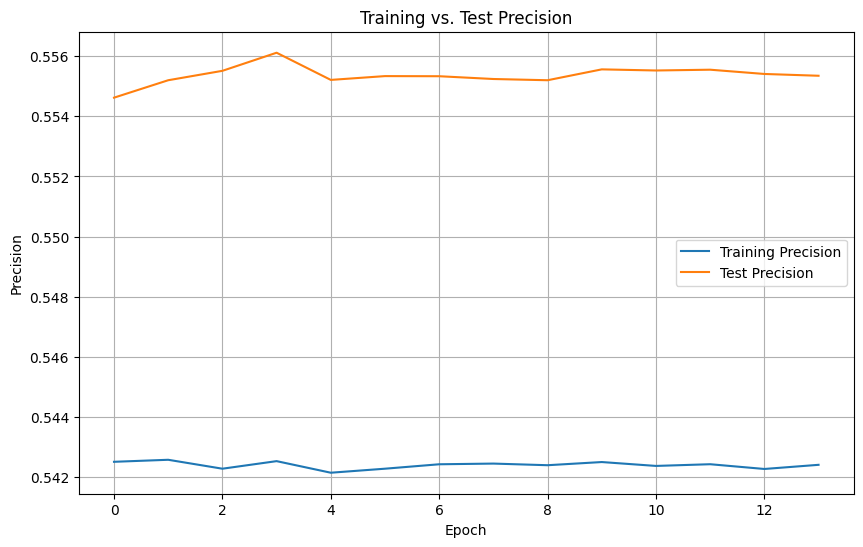

In [344]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_10'], label='Training Precision')
plt.plot(best_history_nn['val_precision_10'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) Different Decision rules to improve precision (varying threshold)

best model1 (clf_best): Decision Tree (max_depth=15)
best model2 (rf_best): Random Forest (n_estimators=200, max_depth=17)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [345]:
# y_pred_test = best_lr.predict_proba(X_test)

# predicting probability instead of a lable

y_pred_test = rf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [346]:
# example prediction of probabilities
y_pred_test

array([[0.55542573, 0.44457427],
       [0.5051903 , 0.4948097 ],
       [0.46000088, 0.53999912],
       ...,
       [0.46705893, 0.53294107],
       [0.44661125, 0.55338875],
       [0.49467782, 0.50532218]])

In [347]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.444574
1,0.494810
2,0.539999
3,0.513030
4,0.521465


In [348]:
# Mean prediction is 0.52, median is 0.58, 75% quantile is 0.75
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,29829.0,0.509048,0.044838,0.341161,0.477998,0.50766,0.539354,0.692381


In [349]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

0.5551979617151095

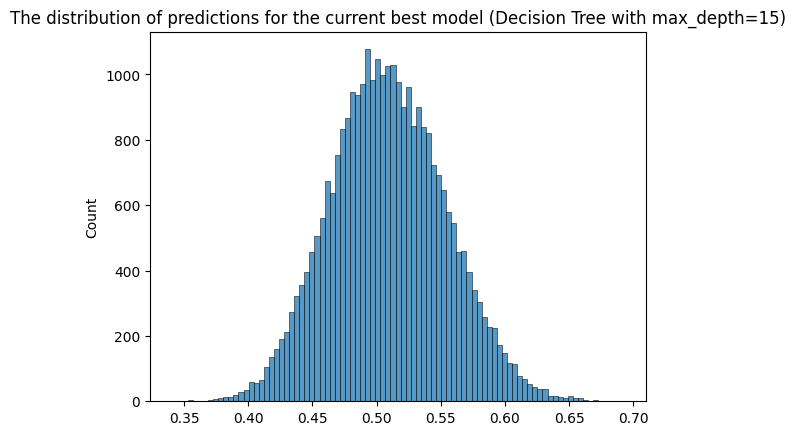

In [350]:
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

In [351]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [352]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [353]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
1,0.02,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
2,0.04,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
3,0.06,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
4,0.08,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
5,0.10,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
6,0.12,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
7,0.14,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
8,0.16,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000
9,0.18,16561,13268,0,0,0.555198,1.000000,0.555198,0.713990,1.000000,1.000000


In [354]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,9692,7211,6869,6057,0.573389,0.585230,0.527976,0.579249,0.585230,0.543488
26,0.52,6845,4962,9716,8306,0.579741,0.413320,0.507929,0.482586,0.413320,0.373983
27,0.54,4281,3035,12280,10233,0.585156,0.258499,0.486573,0.358588,0.258499,0.228746
28,0.56,2368,1562,14193,11706,0.602545,0.142987,0.471823,0.231126,0.142987,0.117727
29,0.58,1136,677,15425,12591,0.626586,0.068595,0.460190,0.123653,0.068595,0.051025
30,0.60,473,222,16088,13046,0.680576,0.028561,0.453217,0.054822,0.028561,0.016732
31,0.62,184,56,16377,13212,0.766667,0.011110,0.449093,0.021903,0.011110,0.004221
32,0.64,64,15,16497,13253,0.810127,0.003865,0.446445,0.007692,0.003865,0.001131
33,0.66,12,3,16549,13265,0.800000,0.000725,0.445104,0.001448,0.000725,0.000226
34,0.68,1,0,16560,13268,1.000000,0.000060,0.444836,0.000121,0.000060,0.000000


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

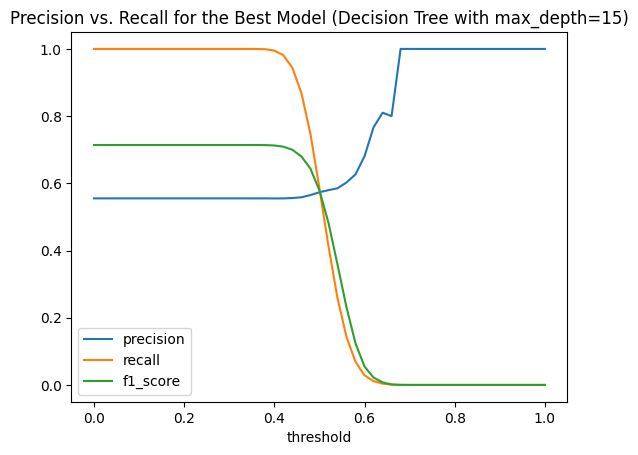

In [355]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [356]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred7'] = y_pred_all_class1_array
new_df['pred7_clf_best_rule_66'] = (y_pred_all_class1_array >= 0.66).astype(int)

new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_best_rule_78'] = (y_pred_all_class1_array >= 0.78).astype(int)

In [357]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=17, n_estimators=200, n_jobs=-1,
                       random_state=42)

In [358]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules: Threshold = 0.66 and 0.78

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_60'] = (y_pred_all_class1_array >= 0.6).astype(int)

# new predictors
new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred12_rf_best_rule_51'] = (y_pred_all_class1_array >= 0.51).astype(int)

new_df['proba_pred12'] = y_pred_all_class1_array
new_df['pred13_rf_best_rule_52'] = (y_pred_all_class1_array >= 0.52).astype(int)

new_df['proba_pred13'] = y_pred_all_class1_array
new_df['pred14_rf_best_rule_53'] = (y_pred_all_class1_array >= 0.53).astype(int)

new_df['proba_pred14'] = y_pred_all_class1_array
new_df['pred15_rf_best_rule_54'] = (y_pred_all_class1_array >= 0.54).astype(int)

new_df['proba_pred15'] = y_pred_all_class1_array
new_df['pred15_rf_best_rule_56'] = (y_pred_all_class1_array >= 0.56).astype(int)

new_df['proba_pred16'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_57'] = (y_pred_all_class1_array >= 0.57).astype(int)

new_df['proba_pred17'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_58'] = (y_pred_all_class1_array >= 0.58).astype(int)

new_df['proba_pred18'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_59'] = (y_pred_all_class1_array >= 0.59).astype(int)


In [359]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict='is_positive_growth_5d_future')

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60', 'pred12_rf_best_rule_51', 'pred13_rf_best_rule_52', 'pred14_rf_best_rule_53', 'pred15_rf_best_rule_54', 'pred15_rf_best_rule_56', 'pred11_rf_best_rule_57', 'pred11_rf_best_rule_58', 'pred11_rf_best_rule_59']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred12', 'is_correct_pred13', 'is_correct_pred14', 'is_correct_pred15', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1

In [360]:
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60',
 'pred12_rf_best_rule_51',
 'pred13_rf_best_rule_52',
 'pred14_rf_best_rule_53',
 'pred15_rf_best_rule_54',
 'pred15_rf_best_rule_56',
 'pred11_rf_best_rule_57',
 'pred11_rf_best_rule_58',
 'pred11_rf_best_rule_59']

<Axes: >

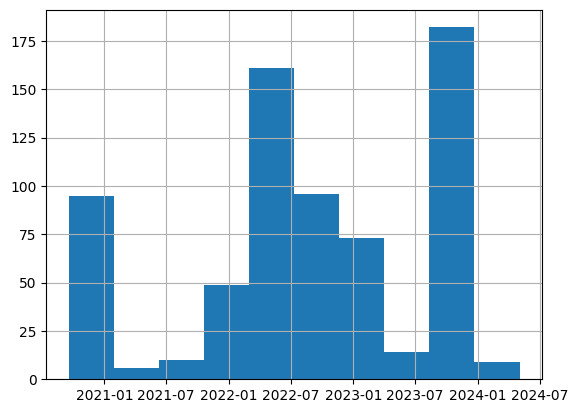

In [361]:
# When did it predict to trade for the "rare" prediction pred10? (only 2%)
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].Date.hist()

In [362]:
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].sort_values(by='Date')

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,pred11_rf_best_rule_59,is_correct_pred7,is_correct_pred8,is_correct_pred9,is_correct_pred10,is_correct_pred12,is_correct_pred13,is_correct_pred14,is_correct_pred15,is_correct_pred11
5326,756.000000,759.599976,744.000000,744.000000,726.495850,85106.0,RMS.PA,2020,September,4,...,1,1,1,0,0,0,0,0,0,0
5327,276.000000,276.100006,269.600006,271.100006,256.523193,590993.0,OR.PA,2020,September,0,...,1,0,0,1,1,1,1,1,1,1
4823,47.689999,48.369999,47.570000,48.270000,47.062443,1151700.0,HDB,2020,September,1,...,1,0,0,1,1,1,1,1,1,1
5420,13.770000,13.810000,13.560000,13.590000,12.568239,7495000.0,INFY,2020,September,2,...,1,0,0,1,1,1,1,1,1,1
6298,155.300003,155.639999,151.830002,152.110001,143.006088,449500.0,SAP,2020,September,2,...,1,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3594,22.600000,23.049999,22.600000,22.740000,22.740000,86700.0,IDEXY,2024,May,2,...,1,1,1,0,0,0,0,0,0,0
7204,181.699997,183.429993,179.149994,180.070007,180.070007,622200.0,SAP,2024,May,2,...,1,1,1,0,0,0,0,0,0,0
7041,396.609985,402.320007,396.350006,398.579987,398.579987,2605000.0,BRK-B,2024,May,2,...,1,1,1,0,0,0,0,0,0,0
4057,268.149994,270.910004,266.709991,267.320007,267.320007,6119900.0,V,2024,May,2,...,1,1,1,0,0,0,0,0,0,0


In [363]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_60==1)].groupby('Date')['pred10_rf_best_rule_60'].count())

In [364]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred9_rf_best_rule_55==1)].groupby('Date')['pred9_rf_best_rule_55'].count())

In [365]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

947

In [366]:
pred10_daily_positive_count

,pred10_rf_best_rule_60
Date,
2020-09-18,1
2020-09-21,1
2020-09-22,1
2020-09-23,6
2020-09-24,4
...,...
2023-11-13,1
2023-11-17,1
2024-01-08,1


array([[<Axes: title={'center': 'pred10_rf_best_rule_60'}>]], dtype=object)

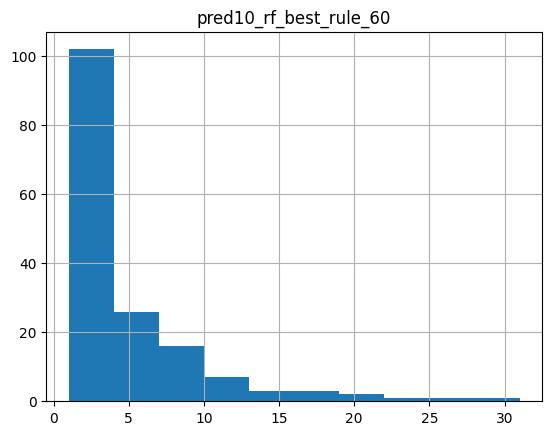

In [367]:
pred10_daily_positive_count.hist()

In [368]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_60,162.0,4.290123,4.998984,1.0,1.0,2.0,6.0,31.0


array([[<Axes: title={'center': 'pred9_rf_best_rule_55'}>]], dtype=object)

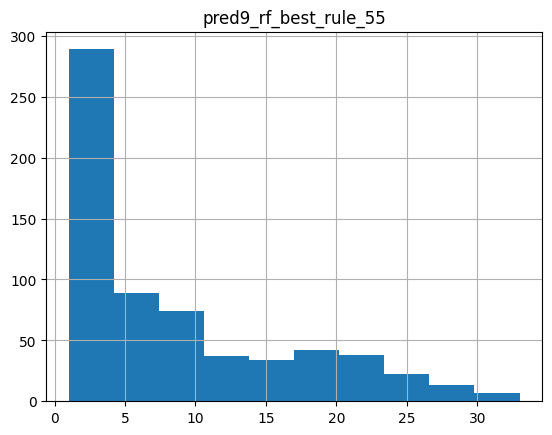

In [369]:
pred9_daily_positive_count.hist()

In [370]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred9_rf_best_rule_55,645.0,8.474419,7.903025,1.0,2.0,6.0,13.0,33.0


## 2.3) Agg. stats on ALL predictions

In [371]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_gdp_and_fastd', 'pred4_manual_gdp_and_wti30d', 'pred5_clf_10', 'pred6_clf_best', 'pred7_clf_best_rule_66', 'pred8_clf_best_rule_78', 'pred9_rf_best_rule_55', 'pred10_rf_best_rule_60', 'pred12_rf_best_rule_51', 'pred13_rf_best_rule_52', 'pred14_rf_best_rule_53', 'pred15_rf_best_rule_54', 'pred15_rf_best_rule_56', 'pred11_rf_best_rule_57', 'pred11_rf_best_rule_58', 'pred11_rf_best_rule_59']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred7', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred12', 'is_correct_pred13', 'is_correct_pred14', 'is_correct_pred15', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1

In [372]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [373]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_gdp_and_fastd',
 'pred4_manual_gdp_and_wti30d',
 'pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60',
 'pred12_rf_best_rule_51',
 'pred13_rf_best_rule_52',
 'pred14_rf_best_rule_53',
 'pred15_rf_best_rule_54',
 'pred15_rf_best_rule_56',
 'pred11_rf_best_rule_57',
 'pred11_rf_best_rule_58',
 'pred11_rf_best_rule_59']

In [374]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_best',
 'pred7_clf_best_rule_66',
 'pred8_clf_best_rule_78',
 'pred9_rf_best_rule_55',
 'pred10_rf_best_rule_60',
 'pred12_rf_best_rule_51',
 'pred13_rf_best_rule_52',
 'pred14_rf_best_rule_53',
 'pred15_rf_best_rule_54',
 'pred15_rf_best_rule_56',
 'pred11_rf_best_rule_57',
 'pred11_rf_best_rule_58',
 'pred11_rf_best_rule_59']

In [375]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred7',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred12',
 'is_correct_pred13',
 'is_correct_pred14',
 'is_correct_pred15',
 'is_correct_pred11']

In [376]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                 test          train    validation
pred5_clf_10           count  29829.000000  123458.000000  29388.000000
                       sum    25644.000000   98448.000000  27563.000000
                       mean       0.859700       0.797421      0.937900
pred6_clf_best         count  29829.000000  123458.000000  29388.000000
                       sum    19828.000000   78085.000000  21163.000000
                       mean       0.664722       0.632482      0.720124
pred7_clf_best_rule_66 count  29829.000000  123458.000000  29388.000000
                       sum     8504.000000   31404.000000   6415.000000
                       mean       0.285092       0.254370      0.218286
pred8_clf_best_rule_78 count  29829.000000  123458.000000  29388.000000
                       sum     5419.000000   23345.000000   3751.000000
                       mean       0.181669       0.189093      0.127637
pred9_rf_best_rule_55  count  29829.000000  123458.000000  29388.000000
                       sum     5466.000000   63447.000000  17685.000000
                       mean       0.183244       0.513916      0.601776
pred10_rf_best_rule_60 count  29829.000000  123458.000000  29388.000000
                       sum      695.000000   48759.000000  14427.000000
                       mean       0.023299       0.394944      0.490915
pred12_rf_best_rule_51 count  29829.000000  123458.000000  29388.000000
                       sum    14315.000000   73457.000000  19899.000000
                       mean       0.479902       0.594996      0.677113
pred13_rf_best_rule_52 count  29829.000000  123458.000000  29388.000000
                       sum    11807.000000   71100.000000  19343.000000
                       mean       0.395823       0.575904      0.658194
pred14_rf_best_rule_53 count  29829.000000  123458.000000  29388.000000
                       sum     9501.000000   68681.000000  18817.000000
                       mean       0.318516       0.556311      0.640295
pred15_rf_best_rule_54 count  29829.000000  123458.000000  29388.000000
                       sum     7316.000000   66104.000000  18248.000000
                       mean       0.245265       0.535437      0.620934
pred15_rf_best_rule_56 count  29829.000000  123458.000000  29388.000000
                       sum     3930.000000   60614.000000  17075.000000
                       mean       0.131751       0.490969      0.581019
pred11_rf_best_rule_57 count  29829.000000  123458.000000  29388.000000
                       sum     2725.000000   57755.000000  16468.000000
                       mean       0.091354       0.467811      0.560365
pred11_rf_best_rule_58 count  29829.000000  123458.000000  29388.000000
                       sum     1813.000000   54855.000000  15817.000000
                       mean       0.060780       0.444321      0.538213
pred11_rf_best_rule_59 count  29829.000000  123458.000000  29388.000000
                       sum     1180.000000   51829.000000  15133.000000
                       mean       0.039559       0.419811      0.514938

In [377]:
# 10 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                       test          train    validation
pred0_manual_cci             count  29829.000000  123458.000000  29388.000000
                             sum      799.000000    3162.000000    875.000000
                             mean       0.026786       0.025612      0.029774
pred1_manual_prev_g1         count  29829.000000  123458.000000  29388.000000
                             sum    15601.000000   62117.000000  15585.000000
                             mean       0.523015       0.503143      0.530318
pred2_manual_prev_g1_and_snp count  29829.000000  123458.000000  29388.000000
                             sum    10455.000000   41609.000000  10902.000000
                             mean       0.350498       0.337030      0.370968
pred3_manual_gdp_and_fastd   count  29829.000000  123458.000000  29388.000000
                             sum    29822.000000  107032.000000  29388.000000
                             mean       0.999765       0.866951      1.000000
pred4_manual_gdp_and_wti30d  count  29829.000000  123458.000000  29388.000000
                             sum        0.000000    5673.000000      0.000000
                             mean       0.000000       0.045951      0.000000
pred5_clf_10                 count  29829.000000  123458.000000  29388.000000
                             sum    25644.000000   98448.000000  27563.000000
                             mean       0.859700       0.797421      0.937900
pred6_clf_best               count  29829.000000  123458.000000  29388.000000
                             sum    19828.000000   78085.000000  21163.000000
                             mean       0.664722       0.632482      0.720124
pred7_clf_best_rule_66       count  29829.000000  123458.000000  29388.000000
                             sum     8504.000000   31404.000000   6415.000000
                             mean       0.285092       0.254370      0.218286
pred8_clf_best_rule_78       count  29829.000000  123458.000000  29388.000000
                             sum     5419.000000   23345.000000   3751.000000
                             mean       0.181669       0.189093      0.127637
pred9_rf_best_rule_55        count  29829.000000  123458.000000  29388.000000
                             sum     5466.000000   63447.000000  17685.000000
                             mean       0.183244       0.513916      0.601776
pred10_rf_best_rule_60       count  29829.000000  123458.000000  29388.000000
                             sum      695.000000   48759.000000  14427.000000
                             mean       0.023299       0.394944      0.490915
pred12_rf_best_rule_51       count  29829.000000  123458.000000  29388.000000
                             sum    14315.000000   73457.000000  19899.000000
                             mean       0.479902       0.594996      0.677113
pred13_rf_best_rule_52       count  29829.000000  123458.000000  29388.000000
                             sum    11807.000000   71100.000000  19343.000000
                             mean       0.395823       0.575904      0.658194
pred14_rf_best_rule_53       count  29829.000000  123458.000000  29388.000000
                             sum     9501.000000   68681.000000  18817.000000
                             mean       0.318516       0.556311      0.640295
pred15_rf_best_rule_54       count  29829.000000  123458.000000  29388.000000
                             sum     7316.000000   66104.000000  18248.000000
                             mean       0.245265       0.535437      0.620934
pred15_rf_best_rule_56       count  29829.000000  123458.000000  29388.000000
                             sum     3930.000000   60614.000000  17075.000000
                             mean       0.131751       0.490969      0.581019
pred11_rf_best_rule_57       count  29829.000000  123458.000000  29388.000000
                             sum     2725.000000   57755.000000  16468.000000
                      

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [378]:
# current prediction
pred = 'pred6_clf_best'

In [379]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close.count()

29829

In [380]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

947

In [381]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_5d', 'is_positive_growth_5d_future']

In [382]:
new_df[['growth_future_5d','is_positive_growth_5d_future',pred]]

,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best
3490,0.963003,0,1
3491,0.971143,0,1
3492,0.929709,0,1
3493,0.980114,0,1
3494,1.007291,1,1
...,...,...,...
5422,NaN,0,0
5423,NaN,0,0
5424,NaN,0,0
5425,NaN,0,0


In [383]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)

In [384]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [385]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [386]:
COLUMNS_FIN_RESULT = ['Date','Ticker','Close']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT]

,Date,Ticker,Close,growth_future_5d,is_positive_growth_5d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
8702,2020-09-21,MSFT,202.539993,1.034067,1,1,3.406741,-0.2,3.206741
8703,2020-09-22,MSFT,207.419998,0.999228,0,1,-0.077153,-0.2,-0.277153
8704,2020-09-23,MSFT,200.589996,1.048557,1,1,4.855687,-0.2,4.655687
8705,2020-09-24,MSFT,203.190002,1.045623,1,1,4.562258,-0.2,4.362258
8706,2020-09-25,MSFT,207.820007,0.992157,0,1,-0.784335,-0.2,-0.984335
...,...,...,...,...,...,...,...,...,...
5417,2024-04-23,LT.NS,3610.149902,0.995610,0,1,-0.439036,-0.2,-0.639036
5418,2024-04-24,LT.NS,3634.850098,0.990275,0,1,-0.972532,-0.2,-1.172532
5419,2024-04-25,LT.NS,3652.300049,0.958245,0,1,-4.175451,-0.2,-4.375451
5420,2024-04-26,LT.NS,3605.199951,0.960640,0,1,-3.935979,-0.2,-4.135979


In [387]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

33.0


In [388]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,809.0,24.509271,11.989175,1.0,13.0,32.0,33.0,33.0


In [389]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

sim1_gross_rev_pred6    14477.431798
sim1_fees_pred6         -3965.600000
sim1_net_rev_pred6      10511.831798
dtype: float64

### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [390]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_5d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 5 * sim1_q75_investments_per_day # 5 days in a row with positive predictions
  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 799 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    309.04589
sim1_fees_pred0        -159.80000
sim1_net_rev_pred0      149.84589
dtype: float64
        Count Investments in 4 years (on TEST): 799
        Gross Revenue: $309
        Fees (0.2% for buy+sell): $159
        Net Revenue: $149
        Fees are 51 % from Gross Revenue
        Capital Required : $1000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $1149 (Vfinal)
        Average CAGR on TEST (4 years) : 1.036, or 3.6% 
        Average daily stats: 
            Average net revenue per investment: $0.19 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 15601 out of 29829 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    6913.217124


In [391]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [392]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,799,309.045890,-159.8,149.845890,0.517075,0.187542,1.866822,1000.0,1.035523,1.149846
1,pred1_manual_prev_g1,15601,6913.217124,-3120.2,3812.817124,0.451338,0.244396,16.526483,11000.0,1.077237,1.346620
2,pred2_manual_prev_g1_and_snp,10455,4213.424501,-2091.0,2139.624501,0.496271,0.204651,21.918239,13000.0,1.038826,1.164587
3,pred3_manual_gdp_and_fastd,29822,14893.285316,-5964.4,8961.885316,0.400476,0.300513,31.491024,16500.0,1.114555,1.543145
4,pred4_manual_gdp_and_wti30d,0,0.000000,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
5,pred5_clf_10,25644,15578.953119,-5128.8,10483.153119,0.329213,0.408796,31.311355,16500.0,1.130843,1.635343
6,pred6_clf_best,19828,14477.431798,-3965.6,10511.831798,0.273916,0.530151,24.509271,16500.0,1.131143,1.637081
7,pred7_clf_best_rule_66,8504,6977.651882,-1700.8,5276.851882,0.243750,0.620514,18.608315,16000.0,1.073858,1.329803
8,pred8_clf_best_rule_78,5419,4659.937647,-1083.8,3576.137647,0.232578,0.659926,15.891496,14500.0,1.056658,1.246630
9,pred9_rf_best_rule_55,5466,5150.760675,-1093.2,4064.360675,0.212240,0.743571,8.474419,6500.0,1.129100,1.625286


In [393]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [394]:
# ANSWER : best rule is pred14_rf_best_rule_53 (THRESHOLD=0.53), with CAGR = 1.1376 - the new global best

## 3.2. Advanced Simulation
* to_predict = 'is_positive_growth_5d_future'
* invest ~20% of capital each day (sell positions from 5 days ago), REINVEST PREVIOUS GAINS
* use predict_proba predictions
* select top1..3..x predictions > threshold (0.53)
* invest proportionally the prediction
* stop loss y%
* take profit z%
* Not included: portfolio optimization

### 3.2.1) [Code Snippet 1] Define rank of prediction (pred_14_rf_best_rule_53)
*  Current best prediction pred_14_rf_best_rule_53, with CAGR = 1.1376 (13.76% average capital growth with simple simulation)

In [395]:
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# rank of prediction

new_df["pred14_rank"] = new_df.groupby("Date")["proba_pred14"].rank(method="first", ascending=False)

<ipython-input-395-f317ee16e759>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [396]:
# CHECK RANK FOR 1 DAY:
  # we have predictions for all 33 stocks
first_trading_day_2024 = new_df[new_df.Date>='2024-01-04'].Date.unique().astype(str)[0]
first_trading_day_2024
print(f'First trading day in 2024: {first_trading_day_2024}, count predictions = {len(new_df[new_df.Date==first_trading_day_2024])}')

First trading day in 2024: 2024-01-04, count predictions = 33


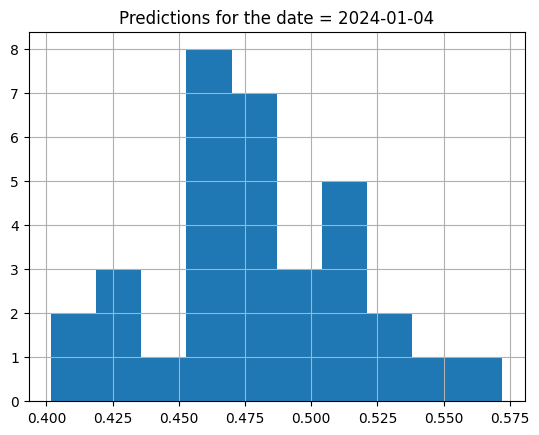

In [397]:
new_df[new_df.Date==first_trading_day_2024].proba_pred14.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()

In [398]:
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker','proba_pred14','pred14_rank']].sort_values(by='pred14_rank').head(5)

,Date,Ticker,proba_pred14,pred14_rank
6172,2024-01-04,RMS.PA,0.572040,1.0
4877,2024-01-04,GOOG,0.540646,2.0
8242,2024-01-04,CDI.PA,0.528151,3.0
6703,2024-01-04,AMZN,0.523443,4.0
6172,2024-01-04,MC.PA,0.518024,5.0


### 3.2.2 Define Min(Low) for the next 5 days and Max(High) for the next 5 days
* Assymetric! distributions for Max_High_Next_5 / Adj_close_today vs. Min_Low_Next_5/Adj_close_today

In [399]:
# Sort the DataFrame by Ticker and Date
new_df = new_df.sort_values(by=['Ticker', 'Date'])

In [400]:
new_df['growth_future_5d'].describe().T

count    182510.000000
mean          1.004208
std           0.049970
min           0.412383
25%           0.980342
50%           1.003817
75%           1.027308
max           3.018887
Name: growth_future_5d, dtype: float64

In [401]:
# take profit if growth >=8%
new_df['growth_future_5d'].quantile(0.95)

1.0770682018177788

In [402]:
# stop loss when -5%
new_df['growth_future_5d'].quantile(0.1)

0.9527185761055379

In [403]:
new_df[['Date','High','Low','Adj Close_x','Ticker']].tail(10)

,Date,High,Low,Adj Close_x,Ticker
4052,2024-04-24,283.000000,274.489990,275.019989,V
4053,2024-04-25,276.220001,270.489990,275.160004,V
4054,2024-04-26,276.769989,273.829987,274.519989,V
4055,2024-04-29,274.470001,271.089996,271.839996,V
4056,2024-04-30,272.079987,268.579987,268.609985,V
4057,2024-05-01,270.910004,266.709991,267.320007,V
4058,2024-05-02,269.470001,266.649994,267.609985,V
4059,2024-05-03,269.450012,266.500000,268.489990,V
4060,2024-05-06,272.779999,269.570007,272.670013,V
4061,2024-05-07,277.880005,272.834991,276.459991,V


In [404]:
# Define a function to get the rolling max High and min Low for the next 5 days

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 5 to calculate the maximum high and minimum low over the next 5 days.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=5):
    # high/low in 5 days
    df['Max_High_Next_5'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_5'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [405]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = new_df[['Date','High','Low','Adj Close_x','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.tail(10)

,Date,High,Low,Adj Close_x,Ticker,Max_High_Next_5,Min_Low_Next_5,Min_Low_Next_1
182665,2024-04-24,283.000000,274.489990,275.019989,V,283.000000,268.579987,270.489990
182666,2024-04-25,276.220001,270.489990,275.160004,V,276.769989,266.709991,273.829987
182667,2024-04-26,276.769989,273.829987,274.519989,V,276.769989,266.649994,271.089996
182668,2024-04-29,274.470001,271.089996,271.839996,V,274.470001,266.500000,268.579987
182669,2024-04-30,272.079987,268.579987,268.609985,V,272.779999,266.500000,266.709991
182670,2024-05-01,270.910004,266.709991,267.320007,V,277.880005,266.500000,266.649994
182671,2024-05-02,269.470001,266.649994,267.609985,V,NaN,NaN,266.500000
182672,2024-05-03,269.450012,266.500000,268.489990,V,NaN,NaN,269.570007
182673,2024-05-06,272.779999,269.570007,272.670013,V,NaN,NaN,272.834991
182674,2024-05-07,277.880005,272.834991,276.459991,V,NaN,NaN,NaN


In [406]:
result[result.Ticker=='AAPL'].tail(10)

,Date,High,Low,Adj Close_x,Ticker,Max_High_Next_5,Min_Low_Next_5,Min_Low_Next_1
6115,2024-04-24,169.300003,166.210007,169.020004,AAPL,176.029999,166.210007,168.149994
6116,2024-04-25,170.610001,168.149994,169.889999,AAPL,176.029999,168.149994,169.179993
6117,2024-04-26,171.339996,169.179993,169.300003,AAPL,176.029999,169.110001,173.100006
6118,2024-04-29,176.029999,173.100006,173.500000,AAPL,187.000000,169.110001,170.000000
6119,2024-04-30,174.990005,170.000000,170.330002,AAPL,187.000000,169.110001,169.110001
6120,2024-05-01,172.710007,169.110001,169.300003,AAPL,187.000000,169.110001,170.889999
6121,2024-05-02,173.419998,170.889999,173.029999,AAPL,NaN,NaN,182.660004
6122,2024-05-03,187.000000,182.660004,183.380005,AAPL,NaN,NaN,180.419998
6123,2024-05-06,184.199997,180.419998,181.710007,AAPL,NaN,NaN,181.320007
6124,2024-05-07,184.899994,181.320007,182.399994,AAPL,NaN,NaN,NaN


In [407]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext5_to_AdjClose'] = np.where(result['Adj Close_x'] == 0, np.nan, result['Max_High_Next_5']/result['Adj Close_x'])
result['Ratio_MinLowNext5_to_AdjClose'] =  np.where(result['Adj Close_x'] == 0, np.nan,  result['Min_Low_Next_5']/result['Adj Close_x'])

result['Ratio_MinLowNext1_to_AdjClose'] =  np.where(result['Adj Close_x'] == 0, np.nan,  result['Min_Low_Next_1']/result['Adj Close_x'])

In [408]:
result[result.Ticker=='AAPL'].tail(10)

,Date,High,Low,Adj Close_x,Ticker,Max_High_Next_5,Min_Low_Next_5,Min_Low_Next_1,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose
6115,2024-04-24,169.300003,166.210007,169.020004,AAPL,176.029999,166.210007,168.149994,1.041474,0.983375,0.994853
6116,2024-04-25,170.610001,168.149994,169.889999,AAPL,176.029999,168.149994,169.179993,1.036141,0.989758,0.995821
6117,2024-04-26,171.339996,169.179993,169.300003,AAPL,176.029999,169.110001,173.100006,1.039752,0.998878,1.022445
6118,2024-04-29,176.029999,173.100006,173.500000,AAPL,187.000000,169.110001,170.000000,1.077810,0.974697,0.979827
6119,2024-04-30,174.990005,170.000000,170.330002,AAPL,187.000000,169.110001,169.110001,1.097869,0.992837,0.992837
6120,2024-05-01,172.710007,169.110001,169.300003,AAPL,187.000000,169.110001,170.889999,1.104548,0.998878,1.009392
6121,2024-05-02,173.419998,170.889999,173.029999,AAPL,NaN,NaN,182.660004,NaN,NaN,1.055655
6122,2024-05-03,187.000000,182.660004,183.380005,AAPL,NaN,NaN,180.419998,NaN,NaN,0.983859
6123,2024-05-06,184.199997,180.419998,181.710007,AAPL,NaN,NaN,181.320007,NaN,NaN,0.997854
6124,2024-05-07,184.899994,181.320007,182.399994,AAPL,NaN,NaN,NaN,NaN,NaN,NaN


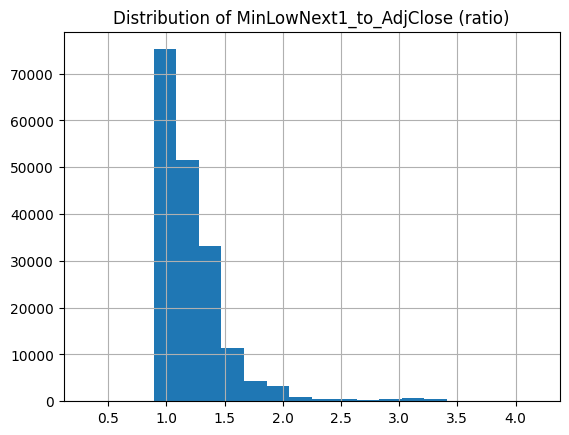

In [409]:
result.Ratio_MinLowNext1_to_AdjClose.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_AdjClose (ratio)')
# Show the plot
plt.show()

In [410]:
result.Ratio_MinLowNext1_to_AdjClose.describe().T

count    182642.000000
mean          1.225722
std           0.301893
min           0.311353
25%           1.027546
50%           1.135659
75%           1.327752
max           4.185120
Name: Ratio_MinLowNext1_to_AdjClose, dtype: float64

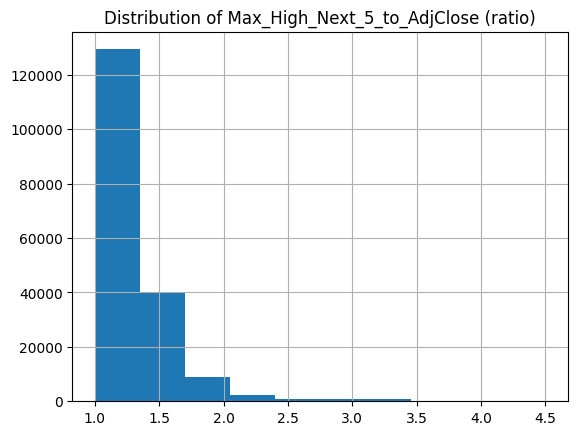

In [411]:
result.Ratio_MaxHighNext5_to_AdjClose.hist()
plt.title(f'Distribution of Max_High_Next_5_to_AdjClose (ratio)')
# Show the plot
plt.show()

In [412]:
result.Ratio_MaxHighNext5_to_AdjClose.describe().T

count    182543.000000
mean          1.282586
std           0.318275
min           1.000000
25%           1.072142
50%           1.188389
75%           1.392367
max           4.505072
Name: Ratio_MaxHighNext5_to_AdjClose, dtype: float64

In [413]:
result[result.Ratio_MaxHighNext5_to_AdjClose>=1.5].tail()

,Date,High,Low,Adj Close_x,Ticker,Max_High_Next_5,Min_Low_Next_5,Min_Low_Next_1,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose
177573,2020-03-20,27.670000,25.420000,19.202631,TTE,36.660000,25.420000,28.170000,1.909113,1.323777,1.466986
177574,2020-03-23,29.580000,28.170000,21.755930,TTE,36.660000,28.170000,31.320000,1.685058,1.294819,1.439607
177575,2020-03-24,33.480000,31.320000,24.906012,TTE,37.500000,31.320000,33.520000,1.505661,1.257528,1.345860
177578,2020-03-27,35.570000,33.369999,27.162100,TTE,41.119999,33.369999,35.770000,1.513874,1.228550,1.316909
177732,2020-11-04,32.830002,31.750000,26.040216,TTE,39.160000,31.750000,32.290001,1.503828,1.219268,1.240005


<Axes: >

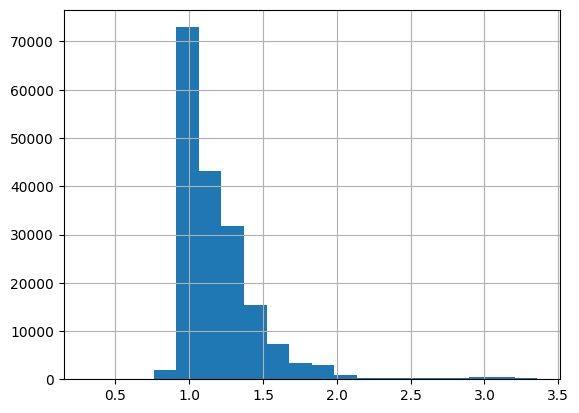

In [414]:
# High intra-day volatility, especially on earlier days after the IPO
result.Ratio_MinLowNext5_to_AdjClose.hist(bins=20)

In [415]:
result.Ratio_MinLowNext5_to_AdjClose.describe().T

count    182543.000000
mean          1.200885
std           0.297079
min           0.302279
25%           1.007737
50%           1.113398
75%           1.300878
max           3.356811
Name: Ratio_MinLowNext5_to_AdjClose, dtype: float64

In [416]:
result[result.Ratio_MinLowNext5_to_AdjClose<=0.9]

,Date,High,Low,Adj Close_x,Ticker,Max_High_Next_5,Min_Low_Next_5,Min_Low_Next_1,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose
184,2000-09-25,0.991071,0.929688,0.808805,AAPL,0.991071,0.453125,0.917411,1.225353,0.560240,1.134280
185,2000-09-26,0.977679,0.917411,0.777624,AAPL,0.977679,0.419643,0.861607,1.257264,0.539647,1.107999
186,2000-09-27,0.941964,0.861607,0.739830,AAPL,0.960938,0.396205,0.859375,1.298864,0.535536,1.161585
187,2000-09-28,0.960938,0.859375,0.808805,AAPL,0.960938,0.390625,0.453125,1.188096,0.482966,0.560240
2597,2010-05-03,9.567143,9.388571,8.053278,AAPL,9.567143,7.116071,9.169643,1.187981,0.883624,1.138622
...,...,...,...,...,...,...,...,...,...,...,...
181627,2020-03-10,182.610001,171.880005,177.536499,V,182.610001,147.979996,170.199997,1.028577,0.833519,0.958676
181628,2020-03-11,178.729996,170.199997,168.154068,V,178.729996,147.979996,156.990005,1.062894,0.880026,0.933608
181629,2020-03-12,172.000000,156.990005,155.640976,V,176.320007,139.800003,162.210007,1.132864,0.898221,1.042206
181630,2020-03-13,176.320007,162.210007,170.954239,V,176.320007,139.800003,147.979996,1.031387,0.817763,0.865612


In [417]:
# ~0.8% STOP LOSS
len(result[result.Ratio_MinLowNext5_to_AdjClose<=0.9])/len(result)

0.008955795812234843

In [418]:
# Merge the results back with the original dataframe
new_df = new_df.merge(result[['Date', 'Ticker', 'Max_High_Next_5', 'Min_Low_Next_5','Ratio_MaxHighNext5_to_AdjClose','Ratio_MinLowNext5_to_AdjClose','Ratio_MinLowNext1_to_AdjClose']], on=['Date', 'Ticker'])

In [419]:
new_df.tail()

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,sim1_net_rev_pred15,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred14_rank,Max_High_Next_5,Min_Low_Next_5,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose
182670,268.149994,270.910004,266.709991,267.320007,267.320007,6119900.0,V,2024,May,2,...,NaN,NaN,-0.2,NaN,6.0,277.880005,266.5,1.039503,0.996932,0.997494
182671,269.350006,269.470001,266.649994,267.609985,267.609985,5061700.0,V,2024,May,3,...,NaN,NaN,0.0,NaN,7.0,NaN,NaN,NaN,NaN,0.995852
182672,269.000000,269.450012,266.500000,268.489990,268.489990,3862000.0,V,2024,May,4,...,NaN,NaN,0.0,NaN,7.0,NaN,NaN,NaN,NaN,1.004023
182673,269.649994,272.779999,269.570007,272.670013,272.670013,3958700.0,V,2024,May,0,...,NaN,NaN,0.0,NaN,22.0,NaN,NaN,NaN,NaN,1.000605
182674,273.720001,277.880005,272.834991,276.459991,276.459991,4965748.0,V,2024,May,1,...,NaN,NaN,0.0,NaN,24.0,NaN,NaN,NaN,NaN,NaN


### 3.2.3) [Code Snippet 2] Generate fin.result for one date

In [420]:
from dataclasses import dataclass

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float

In [421]:
# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=10000,        # initial capital = $10k
    threshold=0.53,               # select all binary predictions with probability>=0.53
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=0.9,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
    take_profit=1.2,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
    lower_entry= 0.995                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
)

print(sim_params)

SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=0.9, take_profit=1.2, lower_entry=0.995)


In [422]:
# sorted array of dates for Simulation
DATES = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')

 Min date 2020-09-14 00:00:00, max date 2024-05-07 00:00:00


In [423]:
date = DATES[0]
date

Timestamp('2020-09-14 00:00:00')

In [424]:
# 1. get TOP_K predictions from pred14_rf_best_rule_53, that are higher than THE THRESHOLD
if sim_params.top_k is None:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred14 > sim_params.threshold)]
else:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred14 > sim_params.threshold)&(new_df.pred14_rank<=sim_params.top_k)]

In [425]:
one_day_predictions_df[['Date','Ticker',to_predict,'growth_future_5d','proba_pred14','pred14_rank']]

,Date,Ticker,is_positive_growth_5d_future,growth_future_5d,proba_pred14,pred14_rank
10943,2020-09-14,ACN,0,0.979400,0.552653,7.0
23193,2020-09-14,ASML,0,0.985541,0.556960,6.0
26906,2020-09-14,AVGO,0,0.980114,0.591758,1.0
38455,2020-09-14,BRK-B,0,0.968537,0.572031,4.0
44695,2020-09-14,CDI.PA,0,0.958513,0.586126,2.0
71153,2020-09-14,IDEXY,1,1.075149,0.562570,5.0
123035,2020-09-14,NVDA,0,0.972421,0.546035,10.0
147732,2020-09-14,RMS.PA,0,0.983779,0.585097,3.0
153875,2020-09-14,SAP,0,0.970006,0.549291,9.0
166162,2020-09-14,SIE.DE,0,0.959945,0.550889,8.0


In [426]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.proba_pred14 - sim_params.threshold +0.01

<ipython-input-426-ebf0c7d597eb>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [427]:
one_day_predictions_df[['Date','Ticker','Adj Close_x', to_predict,'growth_future_5d','proba_pred14','pred14_rank','weight']]

,Date,Ticker,Adj Close_x,is_positive_growth_5d_future,growth_future_5d,proba_pred14,pred14_rank,weight
10943,2020-09-14,ACN,226.498093,0,0.979400,0.552653,7.0,0.032653
23193,2020-09-14,ASML,354.983002,0,0.985541,0.556960,6.0,0.036960
26906,2020-09-14,AVGO,326.022034,0,0.980114,0.591758,1.0,0.071758
38455,2020-09-14,BRK-B,219.940002,0,0.968537,0.572031,4.0,0.052031
44695,2020-09-14,CDI.PA,349.162231,0,0.958513,0.586126,2.0,0.066126
71153,2020-09-14,IDEXY,11.755468,1,1.075149,0.562570,5.0,0.042570
123035,2020-09-14,NVDA,128.389099,0,0.972421,0.546035,10.0,0.026035
147732,2020-09-14,RMS.PA,722.394592,0,0.983779,0.585097,3.0,0.065097
153875,2020-09-14,SAP,151.081955,0,0.970006,0.549291,9.0,0.029291
166162,2020-09-14,SIE.DE,94.257233,0,0.959945,0.550889,8.0,0.030889


In [428]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()

<ipython-input-428-82f470e7f87b>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [429]:
one_day_predictions_df[['Date','Ticker','Adj Close_x', to_predict,'growth_future_5d','proba_pred14','pred14_rank','weight','weight_norm']]

,Date,Ticker,Adj Close_x,is_positive_growth_5d_future,growth_future_5d,proba_pred14,pred14_rank,weight,weight_norm
10943,2020-09-14,ACN,226.498093,0,0.979400,0.552653,7.0,0.032653,0.072016
23193,2020-09-14,ASML,354.983002,0,0.985541,0.556960,6.0,0.036960,0.081516
26906,2020-09-14,AVGO,326.022034,0,0.980114,0.591758,1.0,0.071758,0.158262
38455,2020-09-14,BRK-B,219.940002,0,0.968537,0.572031,4.0,0.052031,0.114754
44695,2020-09-14,CDI.PA,349.162231,0,0.958513,0.586126,2.0,0.066126,0.145841
71153,2020-09-14,IDEXY,11.755468,1,1.075149,0.562570,5.0,0.042570,0.093890
123035,2020-09-14,NVDA,128.389099,0,0.972421,0.546035,10.0,0.026035,0.057421
147732,2020-09-14,RMS.PA,722.394592,0,0.983779,0.585097,3.0,0.065097,0.143572
153875,2020-09-14,SAP,151.081955,0,0.970006,0.549291,9.0,0.029291,0.064602
166162,2020-09-14,SIE.DE,94.257233,0,0.959945,0.550889,8.0,0.030889,0.068126


In [430]:
# 4. Capital: either 1/5 of initial, or everything that you can sell from 5 days ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital/5

<ipython-input-430-cc7c2bbbb3c1>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [431]:
# See the allocation of an 'investment' at a price = 'Adj.Close' * sim_params.lower_entry (e.g. 0.995 - try to buy cheaper)
one_day_predictions_df[['Date','Ticker','Adj Close_x', to_predict,'growth_future_5d','proba_pred14','pred14_rank','weight','weight_norm', 'investment']]

,Date,Ticker,Adj Close_x,is_positive_growth_5d_future,growth_future_5d,proba_pred14,pred14_rank,weight,weight_norm,investment
10943,2020-09-14,ACN,226.498093,0,0.979400,0.552653,7.0,0.032653,0.072016,144.032126
23193,2020-09-14,ASML,354.983002,0,0.985541,0.556960,6.0,0.036960,0.081516,163.032370
26906,2020-09-14,AVGO,326.022034,0,0.980114,0.591758,1.0,0.071758,0.158262,316.523634
38455,2020-09-14,BRK-B,219.940002,0,0.968537,0.572031,4.0,0.052031,0.114754,229.507847
44695,2020-09-14,CDI.PA,349.162231,0,0.958513,0.586126,2.0,0.066126,0.145841,291.681718
71153,2020-09-14,IDEXY,11.755468,1,1.075149,0.562570,5.0,0.042570,0.093890,187.779062
123035,2020-09-14,NVDA,128.389099,0,0.972421,0.546035,10.0,0.026035,0.057421,114.842879
147732,2020-09-14,RMS.PA,722.394592,0,0.983779,0.585097,3.0,0.065097,0.143572,287.143917
153875,2020-09-14,SAP,151.081955,0,0.970006,0.549291,9.0,0.029291,0.064602,129.204411
166162,2020-09-14,SIE.DE,94.257233,0,0.959945,0.550889,8.0,0.030889,0.068126,136.252037


In [432]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_AdjClose']<=sim_params.lower_entry).astype(int)

<ipython-input-432-1fbd186cc433>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [433]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,pred14_rank,Max_High_Next_5,Min_Low_Next_5,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry
10943,237.600006,240.990005,236.809998,238.830002,226.498093,1576400.0,ACN,2020,September,0,...,7.0,244.899994,233.429993,1.081245,1.030605,1.055197,0.032653,0.072016,144.032126,0
23193,369.769989,369.980011,365.359985,367.940002,354.983002,575700.0,ASML,2020,September,0,...,6.0,374.760010,355.140015,1.055713,1.000442,1.039768,0.036960,0.081516,163.032370,0
26906,364.410004,365.890015,359.350006,362.200012,326.022034,1644700.0,AVGO,2020,September,0,...,1.0,372.000000,355.000000,1.141027,1.088883,1.120630,0.071758,0.158262,316.523634,0
38455,219.000000,221.320007,218.300003,219.940002,219.940002,4068800.0,BRK-B,2020,September,0,...,4.0,222.259995,216.500000,1.010548,0.984359,0.993225,0.052031,0.114754,229.507847,1
44695,375.000000,375.000000,369.000000,371.200012,349.162231,6593.0,CDI.PA,2020,September,0,...,2.0,383.600006,369.000000,1.098630,1.056815,1.061970,0.066126,0.145841,291.681718,0
71153,13.620000,13.620000,13.380000,13.440000,11.755468,83100.0,IDEXY,2020,September,0,...,5.0,15.370000,13.380000,1.307477,1.138194,1.197740,0.042570,0.093890,187.779062,0
123035,130.809998,133.149994,126.312500,128.722504,128.389099,120174400.0,NVDA,2020,September,0,...,10.0,133.149994,119.887497,1.037082,0.933783,0.999131,0.026035,0.057421,114.842879,0
147732,745.799988,750.599976,739.599976,739.799988,722.394592,34579.0,RMS.PA,2020,September,0,...,3.0,765.400024,739.599976,1.059532,1.023817,1.026309,0.065097,0.143572,287.143917,0
153875,160.910004,161.630005,159.839996,160.699997,151.081955,389100.0,SAP,2020,September,0,...,9.0,162.169998,158.860001,1.073391,1.051482,1.057704,0.029291,0.064602,129.204411,0
166162,106.372238,106.877052,105.074135,105.326546,94.257233,1303755.0,SIE.DE,2020,September,0,...,8.0,107.850632,104.515228,1.144216,1.108830,1.108830,0.030889,0.068126,136.252037,0


In [434]:
# 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext5_to_AdjClose'] <= sim_params.stop_loss).astype(int)

<ipython-input-434-e50fdb0a5375>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [435]:
# 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext5_to_AdjClose'] >= sim_params.take_profit).astype(int)

<ipython-input-435-055957879913>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [436]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,Min_Low_Next_5,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
10943,237.600006,240.990005,236.809998,238.830002,226.498093,1576400.0,ACN,2020,September,0,...,233.429993,1.081245,1.030605,1.055197,0.032653,0.072016,144.032126,0,0,0
23193,369.769989,369.980011,365.359985,367.940002,354.983002,575700.0,ASML,2020,September,0,...,355.140015,1.055713,1.000442,1.039768,0.036960,0.081516,163.032370,0,0,0
26906,364.410004,365.890015,359.350006,362.200012,326.022034,1644700.0,AVGO,2020,September,0,...,355.000000,1.141027,1.088883,1.120630,0.071758,0.158262,316.523634,0,0,0
38455,219.000000,221.320007,218.300003,219.940002,219.940002,4068800.0,BRK-B,2020,September,0,...,216.500000,1.010548,0.984359,0.993225,0.052031,0.114754,229.507847,1,0,0
44695,375.000000,375.000000,369.000000,371.200012,349.162231,6593.0,CDI.PA,2020,September,0,...,369.000000,1.098630,1.056815,1.061970,0.066126,0.145841,291.681718,0,0,0
71153,13.620000,13.620000,13.380000,13.440000,11.755468,83100.0,IDEXY,2020,September,0,...,13.380000,1.307477,1.138194,1.197740,0.042570,0.093890,187.779062,0,0,1
123035,130.809998,133.149994,126.312500,128.722504,128.389099,120174400.0,NVDA,2020,September,0,...,119.887497,1.037082,0.933783,0.999131,0.026035,0.057421,114.842879,0,0,0
147732,745.799988,750.599976,739.599976,739.799988,722.394592,34579.0,RMS.PA,2020,September,0,...,739.599976,1.059532,1.023817,1.026309,0.065097,0.143572,287.143917,0,0,0
153875,160.910004,161.630005,159.839996,160.699997,151.081955,389100.0,SAP,2020,September,0,...,158.860001,1.073391,1.051482,1.057704,0.029291,0.064602,129.204411,0,0,0
166162,106.372238,106.877052,105.074135,105.326546,94.257233,1303755.0,SIE.DE,2020,September,0,...,104.515228,1.144216,1.108830,1.108830,0.030889,0.068126,136.252037,0,0,0


In [437]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_5d']):
    return row['investment'] # no information on growth in 5 days --> return the same investment in 5 days
  else:
    return row['investment']*(row['growth_future_5d']+(1-sim_params.lower_entry))

In [438]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees


In [439]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

# OLD code when no stop_loss, take_profit, and if order executed
# one_day_predictions_df['investment'] * one_day_predictions_df['growth_future_5d']
# one_day_predictions_df['fees'] =   - one_day_predictions_df['investment'] * sim_params.fees


<ipython-input-439-e8c4292e7229>:2: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-439-e8c4292e7229>:3: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

<ipython-input-439-e8c4292e7229>:4: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [440]:
# result
one_day_predictions_df

,Open,High,Low,Close,Adj Close_x,Volume,Ticker,Year,Month,Weekday,...,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
10943,237.600006,240.990005,236.809998,238.830002,226.498093,1576400.0,ACN,2020,September,0,...,1.055197,0.032653,0.072016,144.032126,0,0,0,144.032126,0.000000,144.032126
23193,369.769989,369.980011,365.359985,367.940002,354.983002,575700.0,ASML,2020,September,0,...,1.039768,0.036960,0.081516,163.032370,0,0,0,163.032370,0.000000,163.032370
26906,364.410004,365.890015,359.350006,362.200012,326.022034,1644700.0,AVGO,2020,September,0,...,1.120630,0.071758,0.158262,316.523634,0,0,0,316.523634,0.000000,316.523634
38455,219.000000,221.320007,218.300003,219.940002,219.940002,4068800.0,BRK-B,2020,September,0,...,0.993225,0.052031,0.114754,229.507847,1,0,0,223.434354,-0.459016,222.975338
44695,375.000000,375.000000,369.000000,371.200012,349.162231,6593.0,CDI.PA,2020,September,0,...,1.061970,0.066126,0.145841,291.681718,0,0,0,291.681718,0.000000,291.681718
71153,13.620000,13.620000,13.380000,13.440000,11.755468,83100.0,IDEXY,2020,September,0,...,1.197740,0.042570,0.093890,187.779062,0,0,1,187.779062,0.000000,187.779062
123035,130.809998,133.149994,126.312500,128.722504,128.389099,120174400.0,NVDA,2020,September,0,...,0.999131,0.026035,0.057421,114.842879,0,0,0,114.842879,0.000000,114.842879
147732,745.799988,750.599976,739.599976,739.799988,722.394592,34579.0,RMS.PA,2020,September,0,...,1.026309,0.065097,0.143572,287.143917,0,0,0,287.143917,0.000000,287.143917
153875,160.910004,161.630005,159.839996,160.699997,151.081955,389100.0,SAP,2020,September,0,...,1.057704,0.029291,0.064602,129.204411,0,0,0,129.204411,0.000000,129.204411
166162,106.372238,106.877052,105.074135,105.326546,94.257233,1303755.0,SIE.DE,2020,September,0,...,1.108830,0.030889,0.068126,136.252037,0,0,0,136.252037,0.000000,136.252037


### 3.2.4 [Code Snippet 3] Wrap up one day simulation into a function

In [441]:
# Simulation Parameters
sim_params = SimulationParams(
    initial_capital=10000,                 # initial capital = $10k
    threshold=0.53,                        # select all binary predictions with probability>=0.53
    fees=0.002,                            # trading fees = 0.2% (buy+sell)
    top_k=10,                              # select top_k predictions
    portfolio_optimization=False,          # no portfolio optimizaiton
    stop_loss=0.9,                         # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
    take_profit=1.2,                       # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
    lower_entry= 0.995                     # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
)

In [442]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='proba_pred14'):
  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_rf_best_rule_53 by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)&(df.pred14_rank<=sim_params.top_k)]

  FIELDS = ['Adj Close_x', 'Ticker', 'Date', predictor, 'pred14_rank', 'growth_future_5d', 'Ratio_MaxHighNext5_to_AdjClose','Ratio_MinLowNext5_to_AdjClose','Ratio_MinLowNext1_to_AdjClose']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_AdjClose'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext5_to_AdjClose'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext5_to_AdjClose'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [443]:
r = one_date_simulation(date='2020-09-14', invest_sum=sim_params.initial_capital/5, df=new_df, sim_params=sim_params, predictor='proba_pred14')

In [483]:
r

,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
10943,226.498093,ACN,2020-09-14,0.552653,7.0,0.979400,1.081245,1.030605,1.055197,0.032653,0.072016,144.032126,0,0,0,144.032126,0.000000,144.032126
23193,354.983002,ASML,2020-09-14,0.556960,6.0,0.985541,1.055713,1.000442,1.039768,0.036960,0.081516,163.032370,0,0,0,163.032370,0.000000,163.032370
26906,326.022034,AVGO,2020-09-14,0.591758,1.0,0.980114,1.141027,1.088883,1.120630,0.071758,0.158262,316.523634,0,0,0,316.523634,0.000000,316.523634
38455,219.940002,BRK-B,2020-09-14,0.572031,4.0,0.968537,1.010548,0.984359,0.993225,0.052031,0.114754,229.507847,1,0,0,223.434354,-0.459016,222.975338
44695,349.162231,CDI.PA,2020-09-14,0.586126,2.0,0.958513,1.098630,1.056815,1.061970,0.066126,0.145841,291.681718,0,0,0,291.681718,0.000000,291.681718
71153,11.755468,IDEXY,2020-09-14,0.562570,5.0,1.075149,1.307477,1.138194,1.197740,0.042570,0.093890,187.779062,0,0,1,187.779062,0.000000,187.779062
123035,128.389099,NVDA,2020-09-14,0.546035,10.0,0.972421,1.037082,0.933783,0.999131,0.026035,0.057421,114.842879,0,0,0,114.842879,0.000000,114.842879
147732,722.394592,RMS.PA,2020-09-14,0.585097,3.0,0.983779,1.059532,1.023817,1.026309,0.065097,0.143572,287.143917,0,0,0,287.143917,0.000000,287.143917
153875,151.081955,SAP,2020-09-14,0.549291,9.0,0.970006,1.073391,1.051482,1.057704,0.029291,0.064602,129.204411,0,0,0,129.204411,0.000000,129.204411
166162,94.257233,SIE.DE,2020-09-14,0.550889,8.0,0.959945,1.144216,1.108830,1.108830,0.030889,0.068126,136.252037,0,0,0,136.252037,0.000000,136.252037


In [445]:
# initial investment
r.investment.sum()

2000.0

In [446]:
# result in 5 days (returns+fees)
r.future_net_return.sum()

1993.4674911534662

### 3.2.5 [Code snippet 4] Generate fin result for ALL days

In [447]:
all_dates = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2020-09-14 00:00:00', '2020-09-15 00:00:00', '2020-09-16 00:00:00',
 '2020-09-17 00:00:00', '2020-09-18 00:00:00', '2020-09-21 00:00:00',
 '2020-09-22 00:00:00', '2020-09-23 00:00:00', '2020-09-24 00:00:00',
 '2020-09-25 00:00:00',
 ...
 '2024-04-24 00:00:00', '2024-04-25 00:00:00', '2024-04-26 00:00:00',
 '2024-04-29 00:00:00', '2024-04-30 00:00:00', '2024-05-01 00:00:00',
 '2024-05-02 00:00:00', '2024-05-03 00:00:00', '2024-05-06 00:00:00',
 '2024-05-07 00:00:00']
Length: 947, dtype: datetime64[ns]

In [448]:
# simulate for all dates but last 5
all_dates[0:-5]

<DatetimeArray>
['2020-09-14 00:00:00', '2020-09-15 00:00:00', '2020-09-16 00:00:00',
 '2020-09-17 00:00:00', '2020-09-18 00:00:00', '2020-09-21 00:00:00',
 '2020-09-22 00:00:00', '2020-09-23 00:00:00', '2020-09-24 00:00:00',
 '2020-09-25 00:00:00',
 ...
 '2024-04-17 00:00:00', '2024-04-18 00:00:00', '2024-04-19 00:00:00',
 '2024-04-22 00:00:00', '2024-04-23 00:00:00', '2024-04-24 00:00:00',
 '2024-04-25 00:00:00', '2024-04-26 00:00:00', '2024-04-29 00:00:00',
 '2024-04-30 00:00:00']
Length: 942, dtype: datetime64[ns]

In [449]:
# these last days we only "sell" the positions
all_dates[-5:]

<DatetimeArray>
['2024-05-01 00:00:00', '2024-05-02 00:00:00', '2024-05-03 00:00:00',
 '2024-05-06 00:00:00', '2024-05-07 00:00:00']
Length: 5, dtype: datetime64[ns]

In [450]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]

2000.0

In [451]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 5 * [sim_params.initial_capital/5]  # first 5 periods trade with 1/5 of the initial_capital. e.g. [2000,2000,2000,2000,2000]

  for current_date in all_dates[0:-5]:  #growth_future_5d is not defined for the last 5 days : ALL, but last 5 dates

    current_invest_sum = capital[-5]    # take the value or everything that you can sell from 5 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor='proba_pred14')

    # add capital available in 5 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-5:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-5:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-5:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-5:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df

In [452]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 10000,        # initial capital = $10k
    threshold = 0.53,               # select all binary predictions with probability>=0.53
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -20% from Adj.Close
    take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +30% from Adj.Close
    lower_entry = 0.99               # buy next day with the price = [Adj.Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 553, fill bids percent = 0.16443651501635445
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 0, net profit = 0.0 
  Start capital = 10000, Resulting capital: 10117.504874439439 
  CAGR in 4 years: 1.003 or 0.29 % of avg. growth per year


### 3.2.5 [Code Snippet 5] Find optimal parameters of simulation

In [453]:
# BEST PREVIOUS CAGR is 0.29%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
# iterate over lower_entry
  # best lower_entry ==0.98
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 0, net profit = 0.0 
  Start capital = 10000, Resulting capital: 10051.962428860958 
  CAGR in 4 years: 1.001 or 0.13 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 0, net profit = 0.0 
  Start capital = 10000, Resulting capital: 106

In [454]:
# BEST PREVIOUS is CAGR 1.48%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99 ==> lower_entry=0.98)

# iterate over lower_entry ++ take profit of 5%
  # best lower_entry ==0.98
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.05,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.05, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 23, net profit = 841.7258537983234 
  Start capital = 10000, Resulting capital: 10791.782625864817 
  CAGR in 4 years: 1.019 or 1.92 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.05, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 54, net profit = 1868.9589670794448 
  Start capita

In [455]:
# BEST PREVIOUS is CAGR 3.66%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 ==> 1.05, lower_entry=0.98)
# BEST PREVIOUS is CAGR 3.05%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 ==> 1.05, lower_entry=0.99)

# iterate over lower_entry ++ take profit of 4%
  # best lower_entry ==0.98
for lower_entry in [0.97,0.98,0.99,1]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.04,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.04, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 38, net profit = 1138.9794415070864 
  Start capital = 10000, Resulting capital: 10956.393537779153 
  CAGR in 4 years: 1.023 or 2.31 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.04, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 81, net profit = 2245.397992681341 
  Start capita

In [456]:
# BEST PREVIOUS is CAGR 4.28%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.05 ==> 1.04, lower_entry=0.98)
# BEST PREVIOUS is CAGR 4.27%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.05 ==> 1.04, lower_entry=0.99)

# iterate over lower_entry ++ take profit of 2.5%
  # best lower_entry ==0.98
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.025,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.025, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 64, net profit = 1532.0440591406586 
  Start capital = 10000, Resulting capital: 11293.78408694949 
  CAGR in 4 years: 1.031 or 3.09 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.025, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 145, net profit = 3089.5061154974246 
  Start cap

In [457]:
# BEST PREVIOUS is CAGR 5.86%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.04 ==> 1.025, lower_entry=0.98)
# BEST PREVIOUS is CAGR 7.35%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.04 ==> 1.025, lower_entry=0.99)

# iterate over lower_entry ++ take profit of 2%
  # best lower_entry ==0.98
for lower_entry in [0.97,0.98,0.99,1, 1.005]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.02,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 74, net profit = 1587.467323752986 
  Start capital = 10000, Resulting capital: 11385.910941924833 
  CAGR in 4 years: 1.033 or 3.3 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 172, net profit = 3266.065650440447 
  Start capital

In [458]:
# BEST PREVIOUS is CAGR 6.3%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.025 ==> 1.02, lower_entry=0.98)
# BEST PREVIOUS is CAGR 8.08%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.025 ==> 1.02, lower_entry=0.99)

# iterate over lower_entry ++ take profit of 1.5%
  # best lower_entry ==0.99 , take_profit= 1.015
for lower_entry in [0.97,0.98,0.99,1, 1.005]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.015,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 88, net profit = 1746.8956530021605 
  Start capital = 10000, Resulting capital: 11518.1450746254 
  CAGR in 4 years: 1.036 or 3.6 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 205, net profit = 3421.070174428358 
  Start capita

In [459]:
# BEST PREVIOUS is CAGR 8.66%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02 ==> 1.015, lower_entry=1)
# BEST PREVIOUS is CAGR 9.43%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02 ==> 1.015, lower_entry=0.99)

# iterate over lower_entry ++ take profit of 1% ==> not optimal, as there are no data points with CAGR >9.43%
for lower_entry in [0.97,0.98,0.99,1, 1.005]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.01,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.01, lower_entry=0.97)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 110, fill bids percent = 0.03270889087124591
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 99, net profit = 1809.8717996383857 
  Start capital = 10000, Resulting capital: 11650.78910794598 
  CAGR in 4 years: 1.039 or 3.89 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.01, lower_entry=0.98)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 264, fill bids percent = 0.07850133809099019
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 229, net profit = 3306.427928593548 
  Start capita

In [484]:
# BEST PREVIOUS is CAGR 8.66%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02 ==> 1.015, lower_entry=1)
# BEST PREVIOUS is CAGR 9.43%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.02 ==> 1.015, lower_entry=0.99)

# iterate over stop_loss AND lower_entry
for stop_loss in [0.8,0.85,0.9,0.95]:
  for lower_entry in [0.99,1]:
    # One simulation
    sim_params = SimulationParams(
        initial_capital = 10000,        # initial capital = $10k
        threshold = 0.53,               # select all binary predictions with probability>=0.53
        fees = 0.002,                   # trading fees = 0.2% (buy+sell)
        top_k = 5,                     # select top_k predictions
        portfolio_optimization = False, # no portfolio optimization
        stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
        take_profit = 1.015,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
        lower_entry = 0.99                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
    )

    res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.99)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 553, fill bids percent = 0.16443651501635445
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 429, net profit = 5646.6870339821035 
  Start capital = 10000, Resulting capital: 14338.56071513925 
  CAGR in 4 years: 1.094 or 9.43 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.99)
 Count bids 3363 in total, avg.bids per day 4.156983930778739,  filled bids 553, fill bids percent = 0.16443651501635445
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 429, net profit = 5646.6870339821035 
  Start ca

In [486]:
# BEST PREVIOUS is CAGR 9.48%  (top_k=5, portfolio_optimization=False, stop_loss=0.85, take_profit = 1.015, lower_entry=0.99)

# iterate over top_k
for top_k in [1,2,4,6,8,10,20,33]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                     # trading fees = 0.2% (buy+sell)
      top_k = top_k,                    # select top_k predictions
      portfolio_optimization = False,   # no portfolio optimization
      stop_loss = 0.8,                 # automatic sell (with loss) if price (any of next 5 days) is lower than
      take_profit = 1.015,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = 0.99                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.99)
 Count bids 809 in total, avg.bids per day 1.0,  filled bids 136, fill bids percent = 0.1681087762669963
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 108, net profit = 6003.5813461967045 
  Start capital = 10000, Resulting capital: 14851.93054492852 
  CAGR in 4 years: 1.104 or 10.39 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=2, portfolio_optimization=False, stop_loss=0.8, take_profit=1.015, lower_entry=0.99)
 Count bids 1544 in total, avg.bids per day 1.9085290482076638,  filled bids 253, fill bids percent = 0.163860103626943
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 191, net profit = 5468.784313729382 
  Start capital = 10000, Re

In [462]:
# only 1 investment
# BEST PREVIOUS CAGR is 10.39%:  lower_entry == 0.99 , take_profit= 1.015, stop_loss=0.85, top_k=1 (invest in max 1 position DAILY)
# BEST PREVIOUS CAGR is 9.59%:   lower_entry == 0.99 , take_profit= 1.015, stop_loss=0.85, top_k=6 (invest in max 6 positions DAILY)

# iterate over lower_entry
for stop_loss in [0.86, 0.88, 0.9,0.94]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 1,                      # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.015,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = 0.99                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)
 Count bids 809 in total, avg.bids per day 1.0,  filled bids 136, fill bids percent = 0.1681087762669963
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 108, net profit = 6003.5813461967045 
  Start capital = 10000, Resulting capital: 14851.93054492852 
  CAGR in 4 years: 1.104 or 10.39 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)
 Count bids 809 in total, avg.bids per day 1.0,  filled bids 136, fill bids percent = 0.1681087762669963
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 108, net profit = 6003.5813461967045 
  Start capital = 10000, Resulting capi

In [463]:
# max 6 investments
# BEST PREVIOUS CAGR is 10.39%:  lower_entry == 0.99 , take_profit= 1.015, stop_loss=0.85, top_k=1 (invest in max 1 position DAILY)
# BEST PREVIOUS CAGR is 9.59%:   lower_entry == 0.99 , take_profit= 1.015, stop_loss=0.85, top_k=6 (invest in max 6 positions DAILY)

# iterate over lower_entry
for stop_loss in [0.86, 0.88, 0.9,0.94]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.53,               # select all binary predictions with probability>=0.53
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 6,                      # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.015,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = 0.99                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=6, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)
 Count bids 3894 in total, avg.bids per day 4.813349814585909,  filled bids 657, fill bids percent = 0.1687211093990755
  Stop loss events: count = 8, net loss = -178.75479401197845 
  Take profit events: count = 512, net profit = 5701.526491182245 
  Start capital = 10000, Resulting capital: 14447.671545722787 
  CAGR in 4 years: 1.096 or 9.64 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=6, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)
 Count bids 3894 in total, avg.bids per day 4.813349814585909,  filled bids 657, fill bids percent = 0.1687211093990755
  Stop loss events: count = 12, net loss = -297.9646057814016 
  Take profit events: count = 512, net profit 

### 3.2.6 Explore the best simulation params (top_k=1)

In [487]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)
 Count bids 809 in total, avg.bids per day 1.0,  filled bids 136, fill bids percent = 0.1681087762669963
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 108, net profit = 6003.5813461967045 
  Start capital = 10000, Resulting capital: 14851.93054492852 
  CAGR in 4 years: 1.104 or 10.39 % of avg. growth per year


In [488]:
res[res.Date=='2024-04-30']
# .future_net_return.sum()

,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
808,22.77,IDEXY,2024-04-30,0.586245,1.0,1.016689,1.022398,0.979798,0.992534,0.066245,1.0,2996.787496,0,0,1,2996.787496,0.0,2996.787496


In [489]:
# number of bids (out of 900+ trading days)
len(res)

809

In [490]:
# filled deals
res.lower_entry.sum()

136

In [491]:
# stop loss (regardless of a filled bid)

res.stop_loss.sum()

2

In [492]:
# take profit (regardless of a filled bid)
res.take_profit.sum()

761

In [493]:
res[(res.stop_loss==1)&(res.lower_entry==1)]

,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return


In [497]:
# could take profit, but the bid was not executed
res[(res.take_profit==1)&(res.lower_entry==0)]

,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
0,326.022034,AVGO,2020-09-14,0.591758,1.0,0.980114,1.141027,1.088883,1.120630,0.071758,1.0,2000.000000,0,0,1,2000.000000,0.0,2000.000000
1,200.331268,V,2020-09-15,0.550213,1.0,0.976484,1.039329,0.971890,1.023055,0.030213,1.0,2000.000000,0,0,1,2000.000000,0.0,2000.000000
2,149.455521,SAP,2020-09-16,0.566871,1.0,0.956847,1.085072,1.024853,1.063661,0.046871,1.0,2000.000000,0,0,1,2000.000000,0.0,2000.000000
3,156.317810,ITC.NS,2020-09-17,0.537195,1.0,0.932531,1.161096,1.098403,1.132309,0.017195,1.0,2000.000000,0,0,1,2000.000000,0.0,2000.000000
4,726.495850,RMS.PA,2020-09-18,0.616821,1.0,0.982527,1.045567,0.992986,0.995463,0.096821,1.0,2000.000000,0,0,1,2000.000000,0.0,2000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,2918.649902,RELIANCE.NS,2024-04-23,0.538439,1.0,1.005259,1.023418,0.987785,0.993267,0.018439,1.0,2996.787496,0,0,1,2996.787496,0.0,2996.787496
805,2919.949951,RELIANCE.NS,2024-04-25,0.581629,1.0,0.982209,1.015822,0.987346,0.993168,0.061629,1.0,2940.767103,0,0,1,2940.767103,0.0,2940.767103
806,2905.100098,RELIANCE.NS,2024-04-26,0.564987,1.0,0.977264,1.021015,0.974941,0.998244,0.044987,1.0,2649.426861,0,0,1,2649.426861,0.0,2649.426861
807,432.619995,META,2024-04-29,0.538578,1.0,1.076418,1.049813,0.987264,0.993297,0.018578,1.0,3585.210570,0,0,1,3585.210570,0.0,3585.210570


In [496]:
res[(res.take_profit==1) &(res.lower_entry==1)]

,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
7,9.328585,IBN,2020-09-23,0.626506,1.0,1.035827,1.065542,0.981928,0.981928,0.106506,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
16,72.671997,GOOG,2020-10-06,0.581070,1.0,1.081352,1.096612,0.988001,0.988001,0.061070,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
81,133.133698,NVDA,2021-01-07,0.572959,1.0,0.989227,1.048645,0.967937,0.979617,0.052959,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
83,256.567780,META,2021-01-11,0.577597,1.0,1.016586,1.026902,0.953393,0.975571,0.057597,1.0,1959.022904,1,0,1,2007.998477,-3.918046,2004.080431
100,143.227951,NVDA,2021-02-22,0.563963,1.0,0.964196,1.056585,0.922742,0.934839,0.043963,1.0,2004.080431,1,0,1,2054.182442,-4.008161,2050.174281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,406.100006,ITC.NS,2024-02-20,0.552093,1.0,1.012435,1.024132,0.988180,0.988180,0.032093,1.0,2573.392079,1,0,1,2637.726881,-5.146784,2632.580097
790,180.000000,SIE.DE,2024-03-06,0.534085,1.0,1.021667,1.016333,0.987000,0.989556,0.014085,1.0,2810.019697,1,0,1,2880.270189,-5.620039,2874.650150
796,315.399994,ACN,2024-04-12,0.544023,1.0,1.004692,1.022511,0.988713,0.989791,0.024023,1.0,2589.860080,1,0,1,2654.606582,-5.179720,2649.426861
800,846.710022,NVDA,2024-04-18,0.580596,1.0,0.975919,1.017940,0.892939,0.892939,0.060596,1.0,2874.650150,1,0,1,2946.516404,-5.749300,2940.767103


In [498]:
res[res.Date=='2024-04-30'].future_net_return.sum()

2996.787495614059

In [499]:
# last 20 days
capital[-20:]

,capital
2024-04-10,2619.490239
2024-04-11,2874.650150
2024-04-12,2589.860080
2024-04-15,3585.210570
2024-04-16,2996.787496
2024-04-17,2619.490239
2024-04-18,2874.650150
2024-04-19,2649.426861
2024-04-22,3585.210570
2024-04-23,2996.787496


capital    14851.930545
dtype: float64


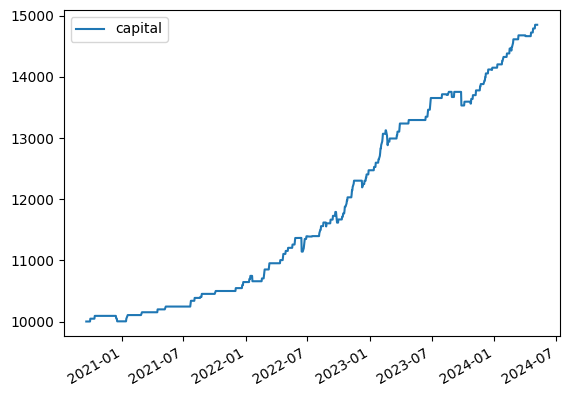

In [500]:
capital.rolling(5).sum().plot.line()
print(capital[-5:].sum())

### Debug optimal strategy with k=6 max trades per day

In [517]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=6, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)

res, capital_6trades = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=6, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)
 Count bids 3894 in total, avg.bids per day 4.813349814585909,  filled bids 657, fill bids percent = 0.1687211093990755
  Stop loss events: count = 8, net loss = -307.4591577187234 
  Take profit events: count = 512, net profit = 5545.6508614581835 
  Start capital = 10000, Resulting capital: 14294.789158919812 
  CAGR in 4 years: 1.093 or 9.34 % of avg. growth per year


In [518]:
# actual loss if wait till the end (0.848) vs. stop_loss (0.86) --> only a very slight defence
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_5d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: 0.8486174004386806


,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
172,140.721527,SAP,2020-10-23,0.570773,6.0,0.713723,1.064585,0.753687,0.804639,0.050773,0.152030,305.553828,1,1,1,265.831830,-0.611108,265.220723
1279,158.917496,AMZN,2022-01-18,0.545936,5.0,0.880872,1.005141,0.851712,0.983215,0.025936,0.137178,299.184874,1,1,0,260.290840,-0.598370,259.692470
1288,250.312988,NVDA,2022-01-19,0.566630,3.0,0.908445,1.060392,0.834475,0.961916,0.046630,0.181941,370.597071,1,1,1,322.419452,-0.741194,321.678258
1687,144.596497,AMZN,2022-04-28,0.593175,2.0,0.805047,1.009274,0.818657,0.841134,0.073175,0.189431,400.947753,1,1,0,348.824545,-0.801896,348.022650
1844,189.022659,NVDA,2022-06-07,0.543054,6.0,0.836909,1.014693,0.825615,0.980570,0.023054,0.100463,211.524768,1,1,0,184.026548,-0.423050,183.603498
2536,164.929077,NVDA,2022-12-21,0.571100,6.0,0.884977,1.008130,0.841816,0.902327,0.051100,0.136112,338.165032,1,1,0,294.203578,-0.676330,293.527248
2667,683.474609,LICI.NS,2023-01-25,0.538050,3.0,0.869016,1.031421,0.852043,0.965654,0.018050,0.153294,380.458392,1,1,1,389.969851,-0.760917,389.208935
3873,493.500000,META,2024-04-24,0.563671,3.0,0.889949,1.033435,0.839919,0.839919,0.043671,0.169222,469.554709,1,1,1,408.512597,-0.939109,407.573488


In [519]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_5d.mean()}')
res[filter_take_profit].head(10)

Average real close price if not take_profit: 0.9985172960460851


,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
9,129.573502,NVDA,2020-09-15,0.547812,4.0,0.972808,1.026348,0.918745,0.965765,0.027812,0.164250,328.500257,1,0,1,336.712764,-0.657001,336.055763
15,124.820839,NVDA,2020-09-16,0.552221,4.0,0.968776,1.048923,0.953727,0.964162,0.032221,0.150593,301.186798,1,0,1,308.716468,-0.602374,308.114094
26,197.619781,V,2020-09-18,0.563010,6.0,0.973545,1.040989,0.977281,0.985225,0.043010,0.108903,217.806163,1,0,1,223.251317,-0.435612,222.815704
40,9.328585,IBN,2020-09-23,0.626506,1.0,1.035827,1.065542,0.981928,0.981928,0.106506,0.189515,378.156305,1,0,1,387.610213,-0.756313,386.853900
88,159.960007,AMZN,2020-10-05,0.538173,6.0,1.076185,1.028066,0.965866,0.965866,0.018173,0.088141,176.282699,1,0,1,180.689767,-0.352565,180.337201
96,72.671997,GOOG,2020-10-06,0.581070,1.0,1.081352,1.096612,0.988001,0.988001,0.061070,0.196668,394.250495,1,0,1,404.106758,-0.788501,403.318257
127,401.992706,BHARTIARTL.NS,2020-10-14,0.600077,5.0,1.013914,1.024320,0.962055,0.964496,0.080077,0.155136,310.906327,1,0,1,318.678985,-0.621813,318.057172
139,163.635498,AMZN,2020-10-16,0.573801,4.0,0.979127,1.038791,0.953931,0.975565,0.053801,0.162357,324.011756,1,0,1,332.112050,-0.648024,331.464027
141,390.708679,BHARTIARTL.NS,2020-10-16,0.568313,6.0,1.081539,1.086186,0.989840,0.989840,0.048313,0.145797,290.964017,1,0,1,298.238118,-0.581928,297.656189
151,160.850494,AMZN,2020-10-20,0.583825,3.0,1.021548,1.020507,0.970448,0.982279,0.063825,0.164253,330.758440,1,0,1,339.027401,-0.661517,338.365884


In [520]:
# predicted growth is -2..-3% negative on mean and median, realised growth is -1..-2% negative
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_5d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_5d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 0.9774106054304718


,count,mean,std,min,25%,50%,75%,max
growth_future_5d,141.0,0.977411,0.031915,0.873807,0.959094,0.982405,0.99765,1.042284
realised_profit,141.0,0.985411,0.031915,0.881807,0.967094,0.990405,1.00565,1.050284


capital    14294.789159
dtype: float64


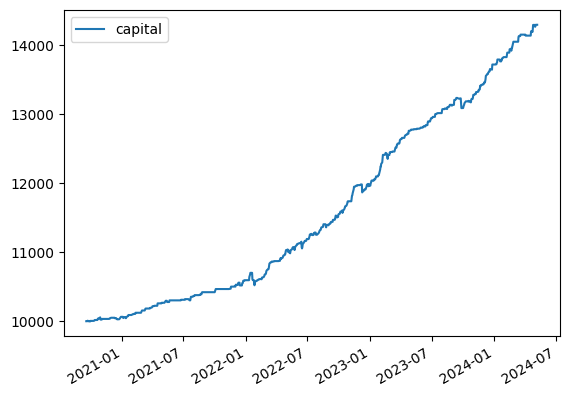

In [521]:
capital_6trades.rolling(5).sum().plot.line()
print(capital_6trades[-5:].sum())

### Debug optimal strategy with k=1 max trades per day

In [522]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)

res, capital_1_trade = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.86, take_profit=1.015, lower_entry=0.99)
 Count bids 809 in total, avg.bids per day 1.0,  filled bids 136, fill bids percent = 0.1681087762669963
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 108, net profit = 6003.5813461967045 
  Start capital = 10000, Resulting capital: 14851.93054492852 
  CAGR in 4 years: 1.104 or 10.39 % of avg. growth per year


In [523]:
# NO STOP LOSS events
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_5d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: nan


,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return


In [524]:
# actual growth of 0.4% if no take profit vs. take_profit 1.5% (+1% from lower entry)
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_5d.mean()}')
res[filter_take_profit].head(5)

Average real close price if not take_profit: 1.004180850277888


,Adj Close_x,Ticker,Date,proba_pred14,pred14_rank,growth_future_5d,Ratio_MaxHighNext5_to_AdjClose,Ratio_MinLowNext5_to_AdjClose,Ratio_MinLowNext1_to_AdjClose,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
7,9.328585,IBN,2020-09-23,0.626506,1.0,1.035827,1.065542,0.981928,0.981928,0.106506,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
16,72.671997,GOOG,2020-10-06,0.581070,1.0,1.081352,1.096612,0.988001,0.988001,0.061070,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
81,133.133698,NVDA,2021-01-07,0.572959,1.0,0.989227,1.048645,0.967937,0.979617,0.052959,1.0,2000.000000,1,0,1,2050.000000,-4.000000,2046.000000
83,256.567780,META,2021-01-11,0.577597,1.0,1.016586,1.026902,0.953393,0.975571,0.057597,1.0,1959.022904,1,0,1,2007.998477,-3.918046,2004.080431
100,143.227951,NVDA,2021-02-22,0.563963,1.0,0.964196,1.056585,0.922742,0.934839,0.043963,1.0,2004.080431,1,0,1,2054.182442,-4.008161,2050.174281


In [525]:
# predicted growth is -2..-3% negative on mean and median, realised growth is -1..-2% negative
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_5d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_5d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 0.9745139981690514


,count,mean,std,min,25%,50%,75%,max
growth_future_5d,28.0,0.974514,0.031869,0.885191,0.958954,0.983728,0.99327,1.02629
realised_profit,28.0,0.982514,0.031869,0.893191,0.966954,0.991728,1.00127,1.03429


capital    14851.930545
dtype: float64


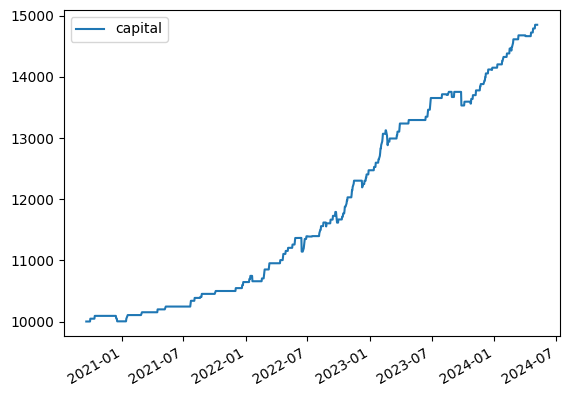

In [526]:
capital_1_trade.rolling(5).sum().plot.line()
print(capital_1_trade[-5:].sum())

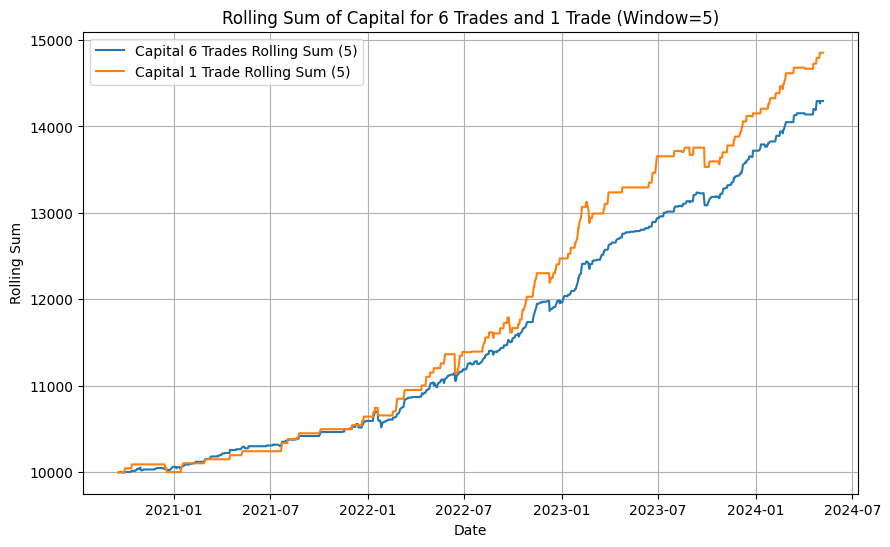

Capital 6 Trades Ending Sum: capital    14294.789159
dtype: float64
Capital 1 Trade Ending Sum: capital    14851.930545
dtype: float64


In [527]:
import matplotlib.pyplot as plt

# Assuming capital_6trades and capital_1_trade are defined and have the same index
capital_6trades_rolling = capital_6trades.rolling(5).sum()
capital_1_trade_rolling = capital_1_trade.rolling(5).sum()

# Plot the rolling sums on the same graph
plt.figure(figsize=(10, 6))
plt.plot(capital_6trades_rolling, label='Capital 6 Trades Rolling Sum (5)')
plt.plot(capital_1_trade_rolling, label='Capital 1 Trade Rolling Sum (5)')
plt.legend(loc='best')
plt.title('Rolling Sum of Capital for 6 Trades and 1 Trade (Window=5)')
plt.xlabel('Date')
plt.ylabel('Rolling Sum')
plt.grid(True)
plt.show()

# Print the ending values
print(f"Capital 6 Trades Ending Sum: {capital_6trades[-5:].sum()}")
print(f"Capital 1 Trade Ending Sum: {capital_1_trade[-5:].sum()}")